In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
#from evaluation_functions import ensemble_evaluation_functions as eef
#import sunspots.sunspots as sunspots
import re  #for dealing with non-numeric characters in a string of unknown length

import matplotlib as mpl
import os
import time

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin

import scipy.interpolate
from scipy import integrate
from scipy.optimize import curve_fit

from sunpy.coordinates.sun import carrington_rotation_time
from sunpy.coordinates.sun import carrington_rotation_number

# ensemble functions
import huxt_ensemble_functions as hef 
import calibration_functions as cf


c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def ICMElist(filepath = None):
    # -*- coding: utf-8 -*-
    """
    A script to read and process Ian Richardson's ICME list.

    Some pre-processing is required:
        Download the following webpage as a html file: 
            http://www.srl.caltech.edu/ACE/ASC/DATA/level3/icmetable2.htm
        Open in Excel, remove the year rows, delete last column (S) which is empty
        Cut out the data table only (delete header and footer)
        Save as a CSV.

    """
    
    if filepath is None:
        datapath =  system._setup_dirs_()['datapath']
        filepath = os.path.join(datapath,
                                'icmetable.csv')
    
    
    icmes=pd.read_csv(filepath,header=None)
    #delete the first row
    icmes.drop(icmes.index[0], inplace=True)
    icmes.index = range(len(icmes))
    
    for rownum in range(0,len(icmes)):
        for colnum in range(0,3):
            #convert the three date stamps
            datestr=icmes[colnum][rownum]
            year=int(datestr[:4])
            month=int(datestr[5:7])
            day=int(datestr[8:10])
            hour=int(datestr[11:13])
            minute=int(datestr[13:15])
            #icmes.set_value(rownum,colnum,datetime(year,month, day,hour,minute,0))
            icmes.at[rownum,colnum] = datetime.datetime(year,month, day,hour,minute,0)
            
        #tidy up the plasma properties
        for paramno in range(10,17):
            dv=str(icmes[paramno][rownum])
            if dv == '...' or dv == 'dg' or dv == 'nan':
                #icmes.set_value(rownum,paramno,np.nan)
                icmes.at[rownum,paramno] = np.nan
            else:
                #remove any remaining non-numeric characters
                dv=re.sub('[^0-9]','', dv)
                #icmes.set_value(rownum,paramno,float(dv))
                icmes.at[rownum,paramno] = float(dv)
        
    
    #chage teh column headings
    icmes=icmes.rename(columns = {0:'Shock_time',
                                  1:'ICME_start',
                                  2:'ICME_end',
                                  10:'dV',
                                  11: 'V_mean',
                                  12:'V_max',
                                  13:'Bmag',
                                  14:'MCflag',
                                  15:'Dst',
                                  16:'V_transit'})
    return icmes

In [3]:
# omni data directory
omni_data_dir = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\OMNI\\Processed_omni\\'

# load the data into dataframe and index by datetime
omni_data = pd.read_hdf(omni_data_dir + 'omni_1hour.h5')
omni_data = omni_data.set_index('datetime')
#omni_data = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

## Create verificaton dataset with ICMEs removed from the timeseries
df_ICME = ICMElist("C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_Calibration\\data\\icmetable.csv")
df_ICME = df_ICME.set_index('Shock_time')

# Create a list of ICME (start,end) times 
CME_flags = [*zip(df_ICME.loc['2020':'2023']['ICME_start'], df_ICME.loc['2020':'2023']['ICME_end'])]

# Loop through ICME timing list and remove observations within CME start/end crossing period.
df_temp = omni_data.copy()
for start_time, end_time in CME_flags:
    
    # Replace values with NaN for rows within the specified time period
    df_temp.loc[(df_temp.index >= start_time) & (df_temp.index <= end_time)] = np.nan

    # Remove from time_series 
    #df_filtered = df_temp[~((df_temp.index >= start_time) & (df_temp.index <= end_time))]
    #df_temp = df_filtered.copy()

df_filtered = df_temp.copy()  

c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [80]:
df_ = omni_data.loc['2023'].copy()

# identify where NaN values are located
is_nan = df_['V'].isna()

# find consecutive NaN start and end times
df_['nan_group'] = (is_nan != is_nan.shift()).cumsum() * is_nan

# group by the 'nan_group'
nan_groups = df_[df_['nan_group'] > 0].groupby('nan_group').apply(
    lambda x: (x.index[0], x.index[-1])
)

C:\Users\ct832900\AppData\Local\Temp\ipykernel_23708\2253531483.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nan_groups = df_[df_['nan_group'] > 0].groupby('nan_group').apply(


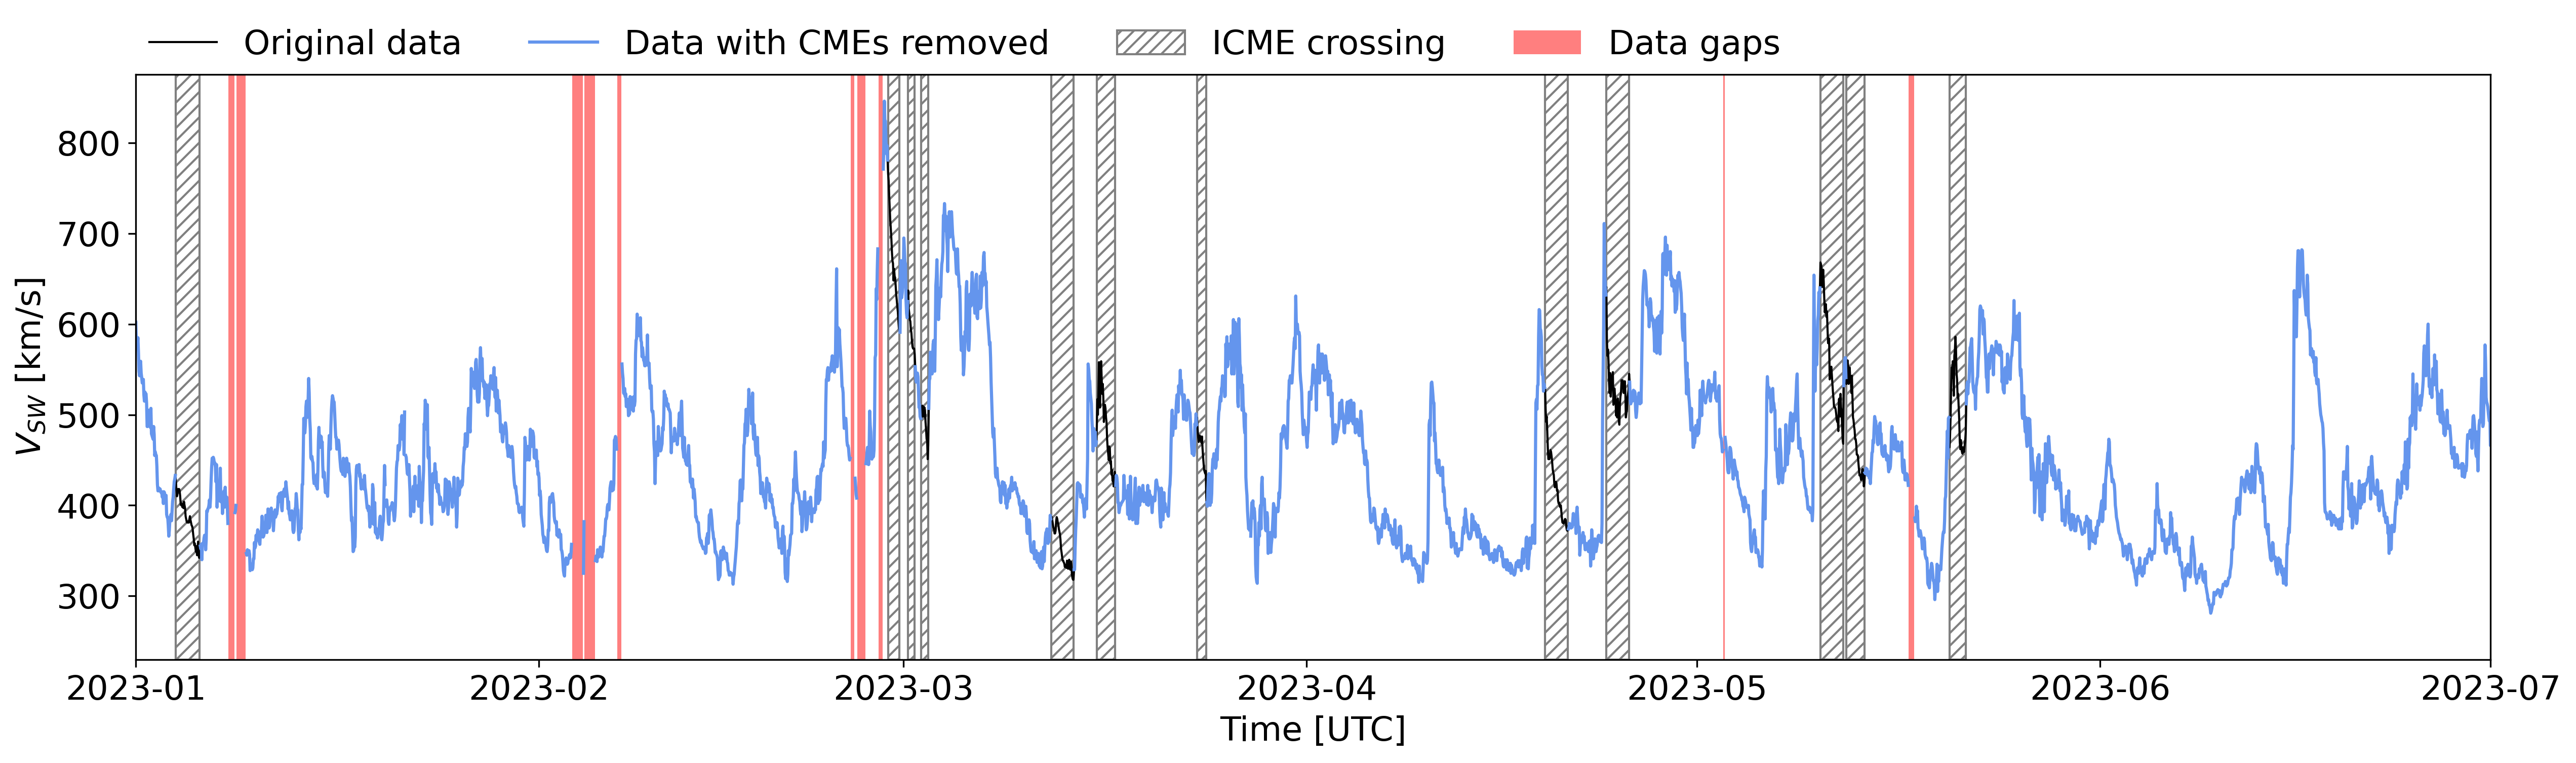

In [79]:
plt.figure(dpi=300, figsize = (20,5))
plt.plot(omni_data.loc['2020':'2023']['V'], label = 'Original data', color = 'black', lw = 1)
plt.plot(df_filtered.loc['2020':'2023']['V'], label = 'Data with CMEs removed', color = 'cornflowerblue')

for start_time, end_time in CME_flags:
    plt.axvspan(start_time, end_time, fill = None , color = 'grey', hatch = '////')
plt.axvspan(start_time, end_time, fill = None , color = 'grey', hatch = '////', label = 'ICME crossing')

for start_time, end_time in nan_groups:
    plt.axvspan(start_time, end_time, lw = 0, color = 'red', alpha = 0.5)
plt.axvspan(start_time, end_time, color = 'red', lw = 0, alpha = 0.5, label = 'Data gaps')

plt.xlabel('Time [UTC]')
plt.ylabel(r'$V_{SW}$ [km/s]')
plt.legend(frameon = False, ncols = 4, loc = (0,1))
plt.xlim('2023-01','2023-07')
#plt.xticks(rotation = 30)


filename = "data_with_cme_removed.pdf"
fpath = f"C:\\Users\\ct832900\\OneDrive - University of Reading\\MC3\\figures\\{filename}"
plt.savefig(fpath, format = 'pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [5]:
def compute_lead_time_stats(df):

    df_ = df.copy()
    
    # Calculating the statistics
    df_['mean'] = df_.mean(axis=1)
    df_['median'] = df_.median(axis=1)
    df_['min'] = df_.min(axis=1)
    df_['max'] = df_.max(axis=1)
    df_['lower_1_sigma'] = df_.apply(lambda row: np.percentile(row, 15.87), axis=1)
    df_['upper_1_sigma'] = df_.apply(lambda row: np.percentile(row, 84.13), axis=1)
    df_['lower_2_sigma'] = df_.apply(lambda row: np.percentile(row, 2.28), axis=1)
    df_['upper_2_sigma'] = df_.apply(lambda row: np.percentile(row, 97.72), axis=1)

    return df_

In [97]:
sigma_latitude = 10
ensemble_size = 100
year_str = '2023'
year_id = {'2023':'', '2020':'_2020'}

# get all WSA files with specified keywords
directory_path = os.path.abspath(os.path.join(os.pardir,'data','ensembles'))
ensemble_file_words = [f'ens_{int(sigma_latitude)}_{ensemble_size}{year_id[year_str]}'] # keywords to filter for in coronal model file directory
ensemble_fname = hef.get_files_containing_words(directory_path, ensemble_file_words)[0]

all_files = os.listdir(os.path.abspath(os.path.join(os.pardir,'data','ensembles',ensemble_fname)))

pattern = r'_(\d{4})(\d{2})(\d{2})(\d{2})'
match = re.search(pattern, all_files[0])
year, month, day, hour = match.groups()
date_string = f'{year}-{month}-{day}--{hour}'

date_strings = []

for file in all_files:

    match = re.search(pattern, file)
    year, month, day, hour = match.groups()
    date_string = f'{year}-{month}-{day}--{hour}'

    date_strings.append(date_strings)

In [6]:
def date_from_ensemble_folder_name(fname):
    
    """
    extracts date from wsa filename

    Args:
        fname (string) : name of ensemble file set
    Returns:
        date_string (string) : date string generated from info within file string format
        date_obj (datetime) : datetime object from file name
    """

    pattern = r'_(\d{4})(\d{2})(\d{2})(\d{2})'
    match = re.search(pattern, fname)
    year, month, day, hour = match.groups()
    date_string = f'{year}-{month}-{day}--{hour}'
    date_obj = datetime.datetime.strptime(date_string, '%Y-%m-%d--%H')

    return date_string, date_obj


In [338]:
# ensemble parameters
ensemble_size = 100
sigma_latitude = 10 # degrees
sigma_longitude = 0 # degrees
forecast_window = 10 * u.day
r_min = 21.5*u.solRad
year_str = '2020'

year_id = {'2023':'', '2020':'_2020'}

# get all ensemble netCDF file strings of specified parameters
ensemble_directory_path = os.path.abspath(os.path.join(os.pardir,'data','ensembles'))
ensemble_file_words = [f'ens_{int(sigma_latitude)}_{ensemble_size}{year_id[year_str]}'] # keywords to filter ensemble set directory
ensemble_fname = hef.get_files_containing_words(ensemble_directory_path, ensemble_file_words)[0]

all_files = os.listdir(os.path.abspath(os.path.join(os.pardir,'data','ensembles',ensemble_fname))) # list of all files inside ensemble directory

dates = []
filenames = []

# creating list of filenames of ensemble files for reading in ensembles over a specfied date range
for filename in all_files:

    #unpack ensemble datenum into an indexable datetime obj
    pattern = r'_(\d{4})(\d{2})(\d{2})(\d{2})'
    match = re.search(pattern, filename)
    year, month, day, hour = match.groups()
    date_string = f'{year}-{month}-{day}--{hour}'
    dates.append(datetime.datetime(int(year), int(month), int(day), int(hour)))

# index ensemble filenames by date
df_ens_filenames = pd.DataFrame({'file_string' : all_files}, index = dates)
df_ens_filenames = df_ens_filenames.sort_index()

# specify date range of ensemble to load in
start_date = datetime.datetime(2020,1,1)
end_date = datetime.datetime(2020,3,1)

date_range = pd.date_range(start_date, end_date, freq='D') # daily frequency

# Finding closest indices
indexer = df_ens_filenames.index.get_indexer(date_range, method='nearest')

# Retrieving the closest rows
closest_files = df_ens_filenames.iloc[indexer]

# Dropping duplicates to keep only unique rows -- unlikely for any duplicates but just in case :/ 
unique_files = closest_files[~closest_files.index.duplicated(keep='first')]

# list of ensemble netCDF filenames within date_range
fname_list = unique_files['file_string'].to_list()

params = ('dummy_fname', ensemble_size, sigma_latitude, forecast_window, r_min)

# Remove rows with NaN values from CME filtered verification dataset
cme_removed_data = df_filtered.dropna(subset = ['V']) 

max_lead_time = 10 # days
lead_time_dict = cf.split_by_lead_time(params=params, sigma_longitude=sigma_longitude, 
                                    max_lead_time=max_lead_time, observed_data=cme_removed_data, 
                                    filenames=fname_list)

IndexError: list index out of range

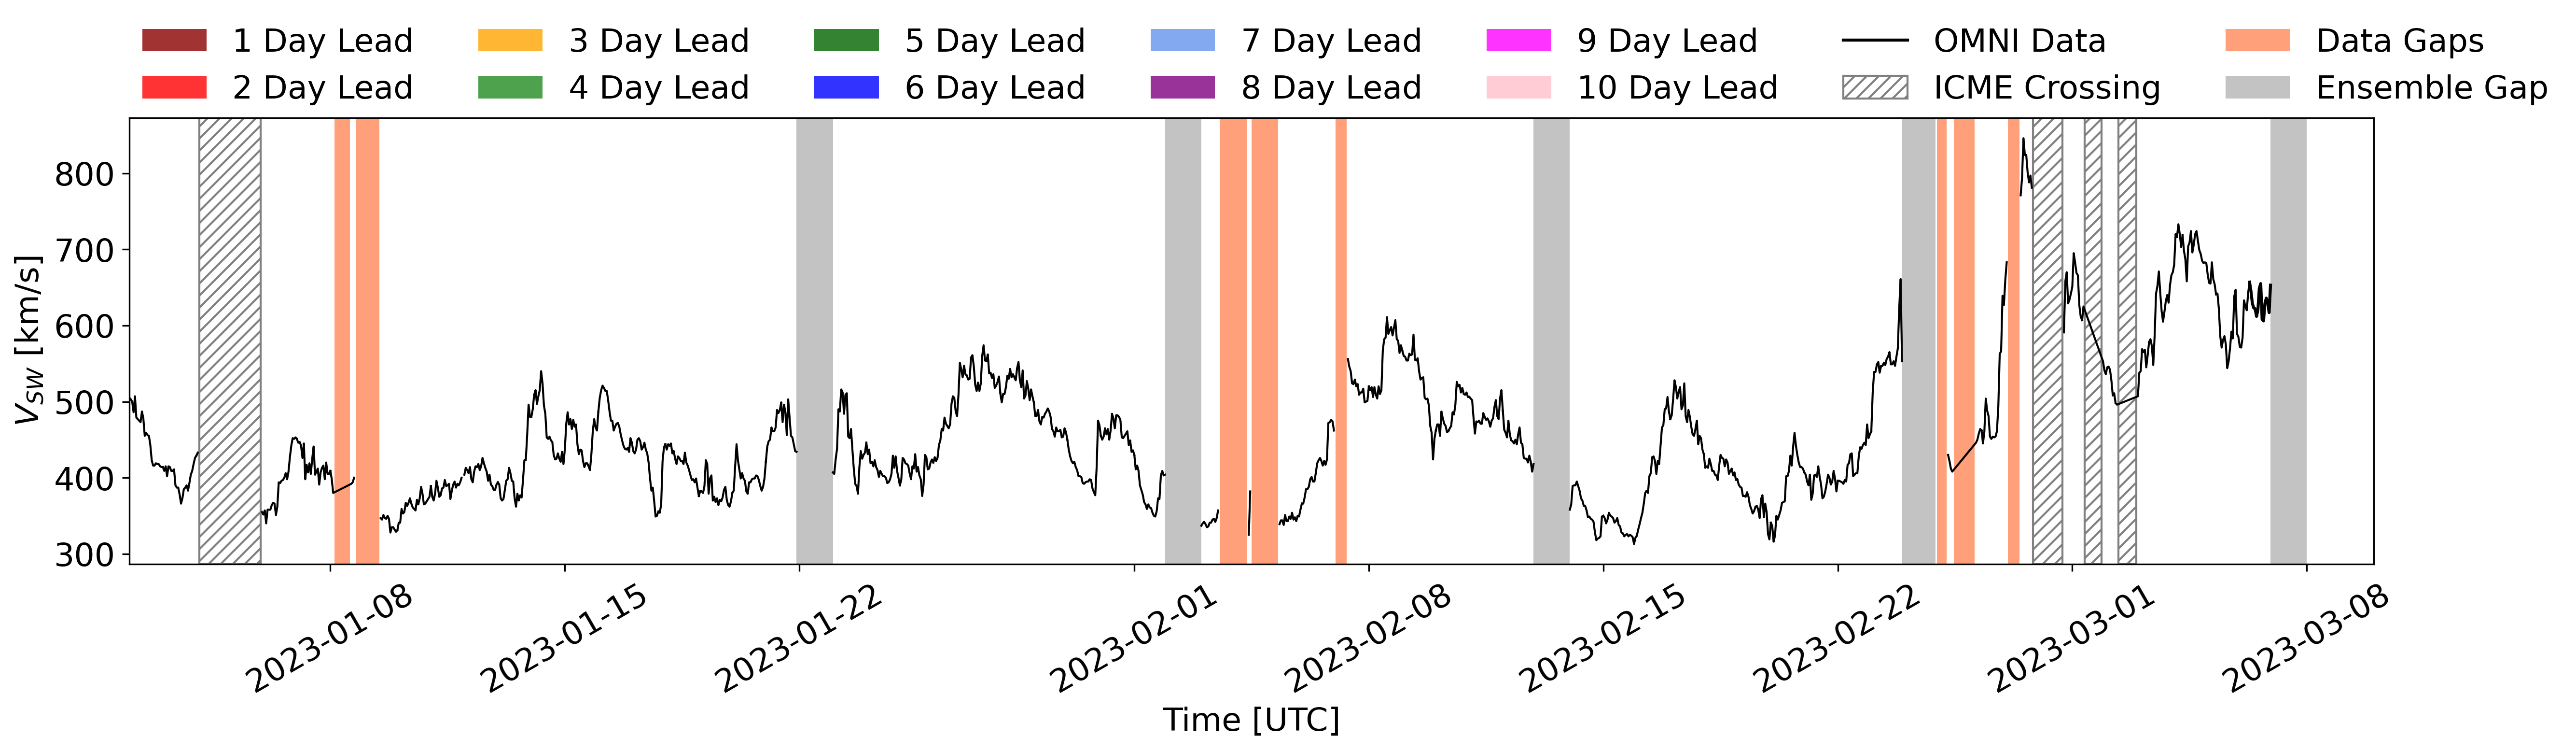

In [85]:
colors = ['darkred', 'red', 'orange', 'forestgreen', 'darkgreen', 'blue', 'cornflowerblue', 'purple', 'magenta', 'pink', 'grey']

plt.figure(dpi=300, figsize = (20,4))
for index in [1,11,22,33,44,55]:

    max_lead_time = 10
    for i in range(max_lead_time):

        # Plot lead time sections (labelling 1st instances)
        if index == 1:

            df_ = lead_time_dict[f'{i+1}_day_lead'][index]
            df_stats = compute_lead_time_stats(df_)

            plt.fill_between(df_stats.index, df_stats['lower_2_sigma'], df_stats['upper_2_sigma'], color = colors[i], alpha = 0.4, edgecolor = None)#, label = r'2$\sigma$')
            plt.fill_between(df_stats.index, df_stats['lower_1_sigma'], df_stats['upper_1_sigma'], label = f'{i+1} Day Lead', color = colors[i], alpha = 0.8, edgecolor = None)#,label = r'1$\sigma$' )
            plt.plot(lead_time_dict[f'{i+1}_day_data'][index], color = 'black', lw = 1)

        else: 

            df_ = lead_time_dict[f'{i+1}_day_lead'][index]
            df_stats = compute_lead_time_stats(df_)

            plt.fill_between(df_stats.index, df_stats['lower_2_sigma'], df_stats['upper_2_sigma'], color = colors[i], alpha = 0.4, edgecolor = None )
            plt.fill_between(df_stats.index, df_stats['lower_1_sigma'], df_stats['upper_1_sigma'], color = colors[i], alpha = 0.8, edgecolor = None )

            #plt.plot(df_[0])
            plt.plot(lead_time_dict[f'{i+1}_day_data'][index], color = 'black', lw = 1)


# Omni data labelling
plt.plot(lead_time_dict[f'{i+1}_day_data'][index], color = 'black', label = 'OMNI Data')

# Mark CME crossings
for start_time, end_time in CME_flags:
    plt.axvspan(start_time, end_time, edgecolor = 'grey', hatch = '////', facecolor= 'white')
plt.axvspan(start_time, end_time , edgecolor = 'grey', hatch = '////', label = 'ICME Crossing', facecolor = 'white')

# Mark datagaps
for start_time, end_time in nan_groups:
    plt.axvspan(start_time, end_time, lw = 0, color = 'lightsalmon', alpha = 1)
plt.axvspan(start_time, end_time, color = 'lightsalmon', lw = 0, alpha = 1, label = 'Data Gaps')


for index in [11,22,33,44,55]:

    df_st = lead_time_dict[f'{10}_day_lead'][index]
    df_end = lead_time_dict[f'{1}_day_lead'][index+10]
    if index == 11:
        plt.axvspan(df_st.index[-1], df_end.index[-1], lw = 0, color = 'dimgrey', alpha = 0.4, label = 'Ensemble Gap')
    else:
        plt.axvspan(df_st.index[-1], df_end.index[-1], lw = 0, color = 'dimgrey', alpha = 0.4)


    # plt.axvline(df_st.index[0], lw = 1, color = 'brown', linestyle='--')
    # plt.axvline(df_end.index[-1], lw = 1, color = 'brown', linestyle='--')

    
plt.xlabel('Time [UTC]')
plt.ylabel(r'$V_{SW}$ [km/s]')
#plt.ylim(250,700)
plt.xlim('2023-01-02','2023-03-10')
plt.xticks(rotation = 30)
plt.legend(frameon=False, ncols = 7, loc = (0,1))

filename = "ensemble_lead_time_series.pdf"
fpath = f"C:\\Users\\ct832900\\OneDrive - University of Reading\\MC3\\figures\\{filename}"
#plt.savefig(fpath, format = 'pdf', dpi = 300, bbox_inches='tight')
plt.show()

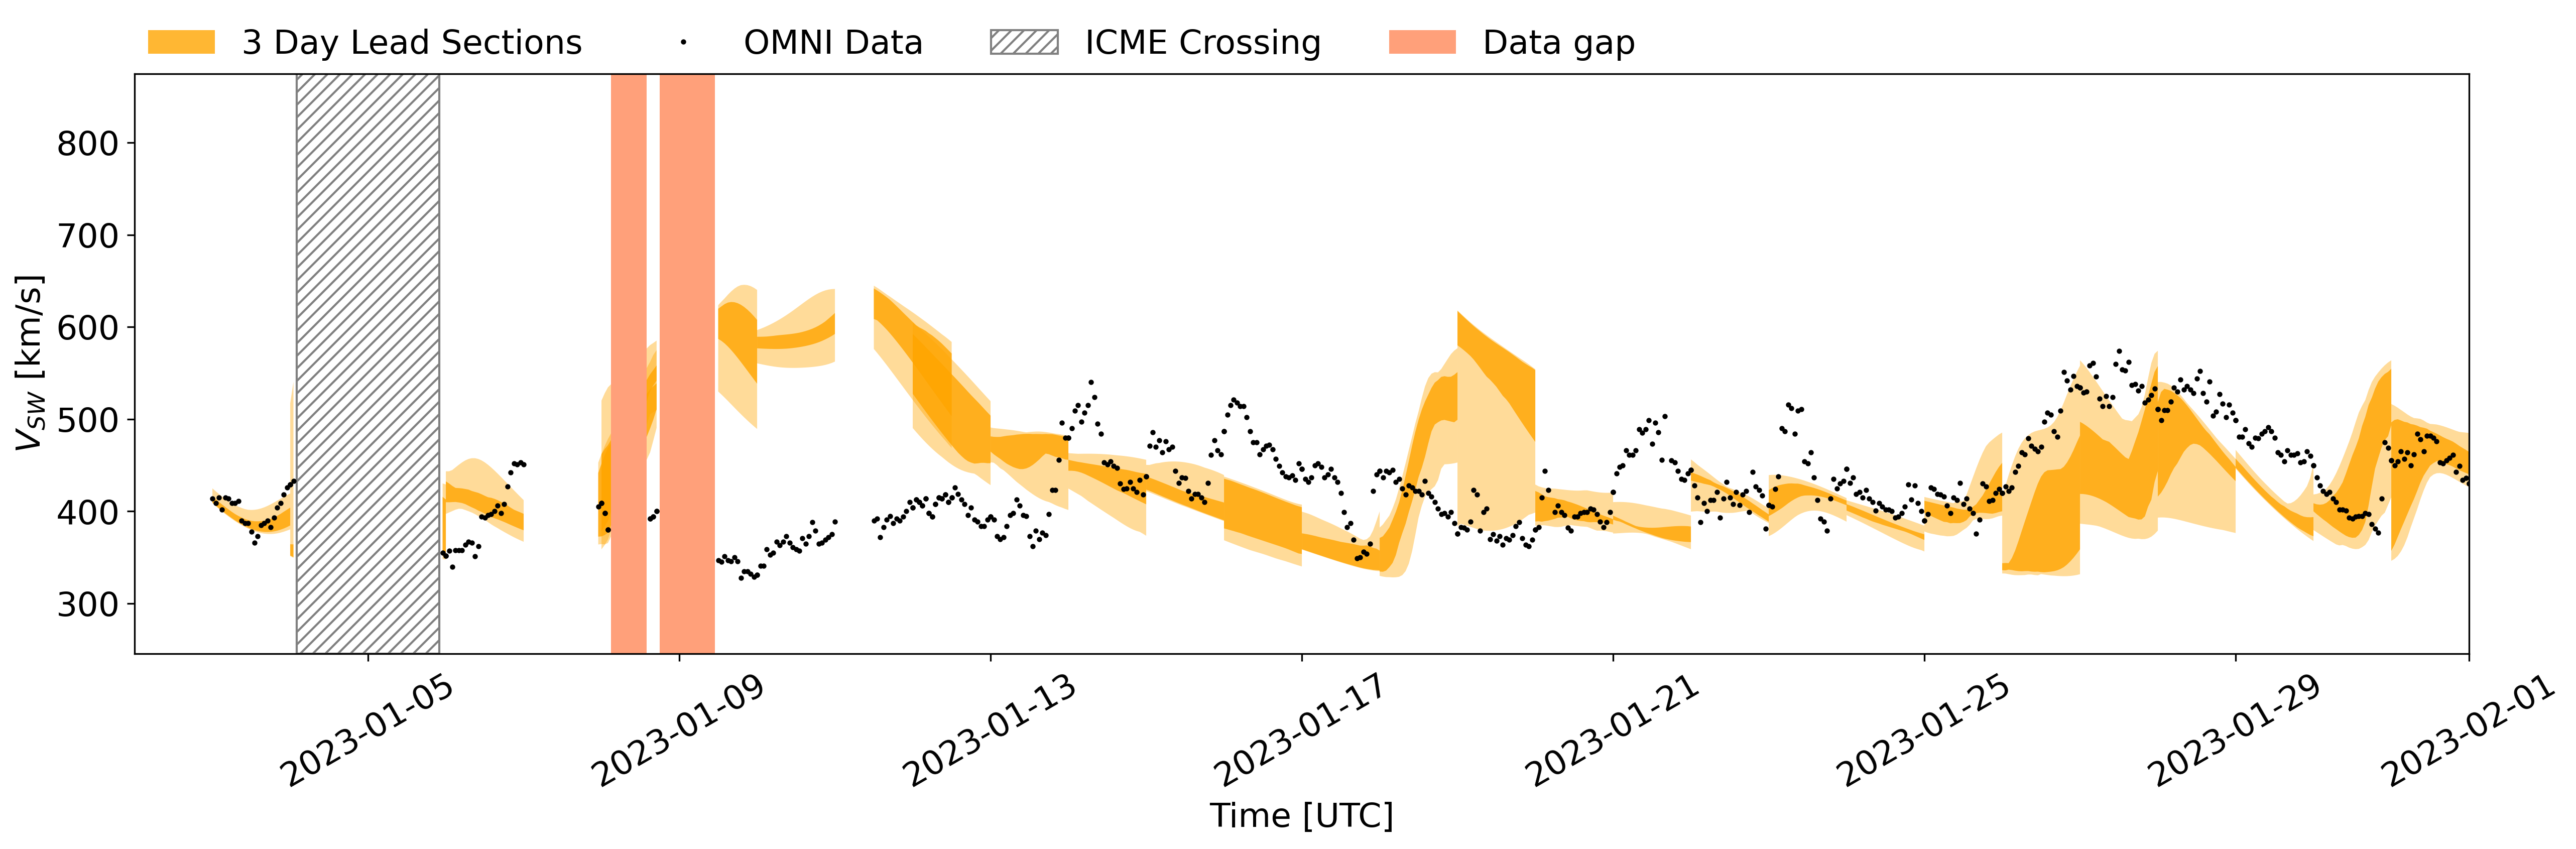

In [ ]:
plt.figure(dpi=300, figsize = (20,5))
ensemble_size=100

lead_time = 3

for df in lead_time_dict[f'{lead_time}_day_lead'][0:33]:
    df_stats = compute_lead_time_stats(df)
    
    plt.fill_between(df_stats.index, df_stats['lower_2_sigma'], df_stats['upper_2_sigma'], color = 'orange', alpha = 0.4, edgecolor = None)#, label = r'2$\sigma$')
    plt.fill_between(df_stats.index, df_stats['lower_1_sigma'], df_stats['upper_1_sigma'], color = 'orange', alpha = 0.8, edgecolor = None)#,label = r'1$\sigma$' )
    
plt.fill_between(df_stats.index, df_stats['lower_1_sigma'], df_stats['upper_1_sigma'], label = f'{lead_time} Day Lead Sections', color = 'orange', alpha = 0.8, edgecolor = None)#,label = r'1$\sigma$' )


for i, _ in enumerate(fname_list):
    plt.plot(lead_time_dict[f'3_day_data'][i], color = 'black', marker = '.', lw = 0, markersize = 3)#, label = 'OMNI Data')
plt.plot(lead_time_dict[f'3_day_data'][i], color = 'black', label = 'OMNI Data', marker = '.', lw = 0, markersize = 3)

# Mark CME crossings
for start_time, end_time in CME_flags:
    plt.axvspan(start_time, end_time, fill = None , edgecolor = 'grey', hatch = '////', facecolor= 'white')
plt.axvspan(start_time, end_time, fill = None , edgecolor = 'grey', hatch = '////', label = 'ICME Crossing', facecolor = 'white')

# Mark datagaps
for start_time, end_time in nan_groups:
    plt.axvspan(start_time, end_time, lw = 0, color = 'lightsalmon', alpha = 1)
plt.axvspan(start_time, end_time, lw = 0, color = 'lightsalmon', alpha = 1, label = 'Data gap')

#plt.axvspan(start_time, end_time, fill = None , color = 'grey', hatch = '////', label = 'ICME crossing')

#plt.ylim(200,650)
plt.xlim('2023-01-02','2023-02')
plt.legend(frameon=False, ncols = 7, loc = (0,1))
plt.xlabel('Time [UTC]')
plt.ylabel(r'$V_{SW}$ [km/s]')
plt.xticks(rotation = 30)

filename = "ensemble_composite_3_day_lead.pdf"
fpath = f"C:\\Users\\ct832900\\OneDrive - University of Reading\\MC3\\figures\\{filename}"
#plt.savefig(fpath, format = 'pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [324]:
# ensemble parameters
ensemble_size = 100
sigma_latitude = 0 # degrees
sigma_longitude = 0 # degrees
forecast_window = 10 * u.day
r_min = 21.5*u.solRad
year_str = '2023'

year_id = {'2023':'', '2020':'_2020'}

# get all ensemble netCDF file strings of specified parameters
ensemble_directory_path = os.path.abspath(os.path.join(os.pardir,'data','ensembles'))
ensemble_file_words = [f'ens_{int(sigma_latitude)}_{ensemble_size}{year_id[year_str]}'] # keywords to filter ensemble set directory
ensemble_fname = hef.get_files_containing_words(ensemble_directory_path, ensemble_file_words)[0]

all_files = os.listdir(os.path.abspath(os.path.join(os.pardir,'data','ensembles',ensemble_fname))) # list of all files inside ensemble directory

dates = []
filenames = []

# creating list of filenames of ensemble files for reading in ensembles over a specfied date range
for filename in all_files:

    #unpack ensemble datenum into an indexable datetime obj
    pattern = r'_(\d{4})(\d{2})(\d{2})(\d{2})'
    match = re.search(pattern, filename)
    year, month, day, hour = match.groups()
    date_string = f'{year}-{month}-{day}--{hour}'
    dates.append(datetime.datetime(int(year), int(month), int(day), int(hour)))

# index ensemble filenames by date
df_ens_filenames = pd.DataFrame({'file_string' : all_files}, index = dates)
df_ens_filenames = df_ens_filenames.sort_index()

# specify date range of ensemble to load in
start_date = datetime.datetime(2023,1,1)
end_date = datetime.datetime(2024,1,1)

date_range = pd.date_range(start_date, end_date, freq='D') # daily frequency

# Finding closest indices
indexer = df_ens_filenames.index.get_indexer(date_range, method='nearest')

# Retrieving the closest rows
closest_files = df_ens_filenames.iloc[indexer]

# Dropping duplicates to keep only unique rows -- unlikely for any duplicates but just in case :/ 
unique_files = closest_files[~closest_files.index.duplicated(keep='first')]

# list of ensemble netCDF filenames within date_range
fname_list = unique_files['file_string'].to_list()

for_lists = []
tim_lists = []
for fname in fname_list:
    date_string, date_obj = date_from_ensemble_folder_name(fname)
    random_seed = int(date_obj.strftime("%y%m%d%H%M"))

    # read in ensemble members
    ensemble_members = hef.read_ens_cdf(date_string=date_string, sigma_latitude=sigma_latitude, ensemble_size=ensemble_size, coronal_model='wsa')

    for_lists.append(ensemble_members[0]['vsw'])
    tim_lists.append(ensemble_members[0].index)
    
data = omni_data['V']['2023-01-01':'2023-03-01']    


tim_lists = [t_lst.to_julian_date() for t_lst in tim_lists]
data['mjd'] = data.index.to_julian_date()


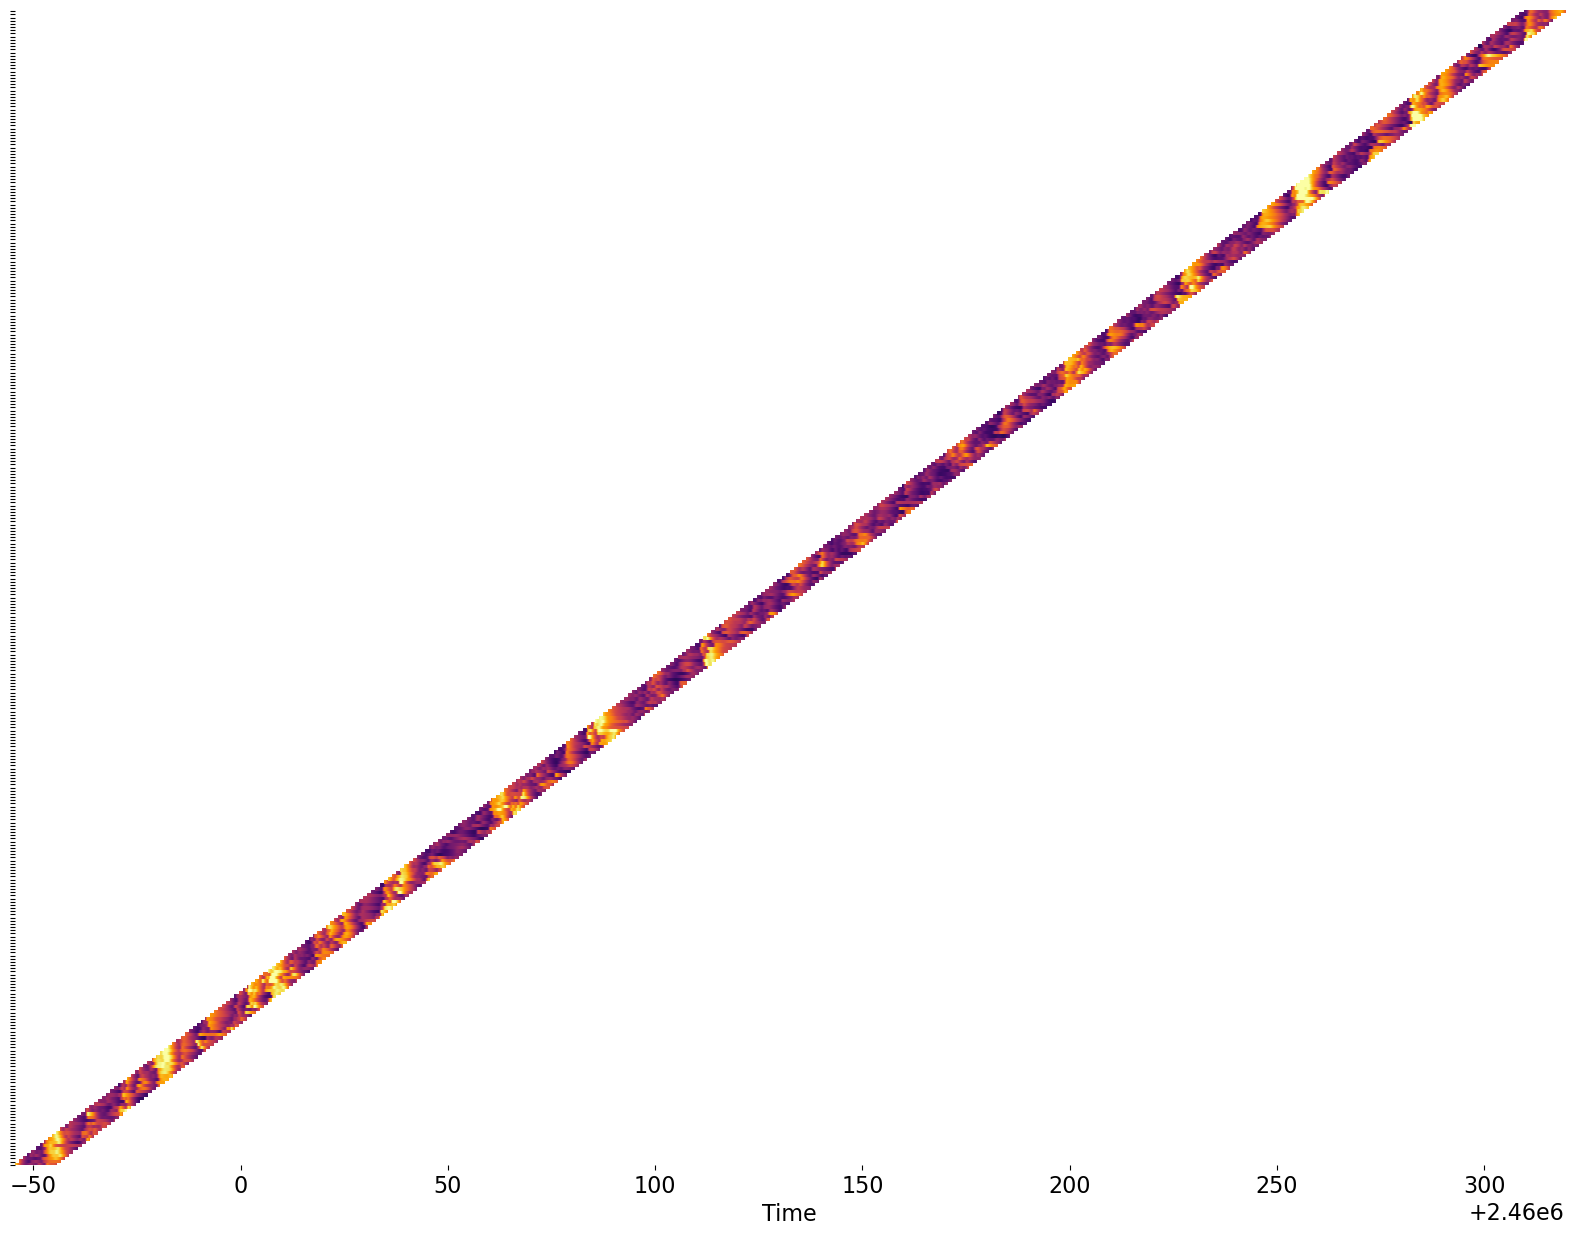

In [328]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 15))


# Create a color map
cmap = plt.get_cmap('inferno')
vmin = 250
vmax= 650

# Plot each time series as a segment in the color bar
for i, (values, times) in enumerate(zip(for_lists, tim_lists)):
    values = np.array(values)
    times = np.array(times)
    norm = plt.Normalize(vmin, vmax)
    colors = cmap(norm(values))
    
    # Create a colored bar for each time series
    ax.imshow([colors], aspect='auto', extent=[times[0], times[-1], i, i + 1])


# Set the x-axis limits to cover all time ranges
all_times = np.concatenate(tim_lists)

#add the observations
# mask = (data['mjd'] >= all_times.min() ) & (data['mjd'] <= all_times.max() )
# norm = plt.Normalize(vmin, vmax)
# colors = cmap(norm(data.loc[mask,'V']))
# # Create a colored bar for each time series
# ax.imshow([colors], aspect='auto', extent=[all_times.min(), all_times.max(), i+1, i + 2])


# Set the axis labels
ax.set_yticks(np.arange(len(tim_lists)) + 0.5)
ax.set_yticklabels([])
#ax.set_yticklabels([f'Leadtime {i}' for i in range(len(tim_lists))])
ax.set_xlabel('Time')


ax.set_xlim(all_times.min(), all_times.max())


# Remove axis lines
ax.spines[:].set_visible(False)

plt.show()




In [323]:
unique_files

,file_string
2023-02-01,ens_0_100_wsa_2023020100.nc
2023-02-02,ens_0_100_wsa_2023020200.nc
2023-02-03,ens_0_100_wsa_2023020300.nc
2023-02-04,ens_0_100_wsa_2023020400.nc
2023-02-05,ens_0_100_wsa_2023020500.nc
2023-02-06,ens_0_100_wsa_2023020600.nc
2023-02-07,ens_0_100_wsa_2023020700.nc
2023-02-08,ens_0_100_wsa_2023020800.nc
2023-02-09,ens_0_100_wsa_2023020900.nc
2023-02-10,ens_0_100_wsa_2023021000.nc


In [334]:
recompiled_forcast_lists = []
recompiled_time_lists = []
recompiled_data = []
max_lead_time=10
number_of_forecasts = 20

for i in range(number_of_forecasts):

    compiled_forecast = [lead_time_dict[f'{j+1}_day_lead'][i][0]['vsw'] for j in range(max_lead_time)]
    recompiled_forcast_lists.append(pd.concat(compiled_forecast))
    recompiled_time_lists.append(pd.concat(compiled_forecast).index.to_julian_date())


recompiled_data = [lead_time_dict[f'1_day_data'][j] for j in range(number_of_forecasts)]

data = cme_removed_data['2023-01-01':f'2024-01-{number_of_forecasts}']
data['mjd'] = data.index.to_julian_date()

C:\Users\ct832900\AppData\Local\Temp\ipykernel_23708\2184494169.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mjd'] = data.index.to_julian_date()


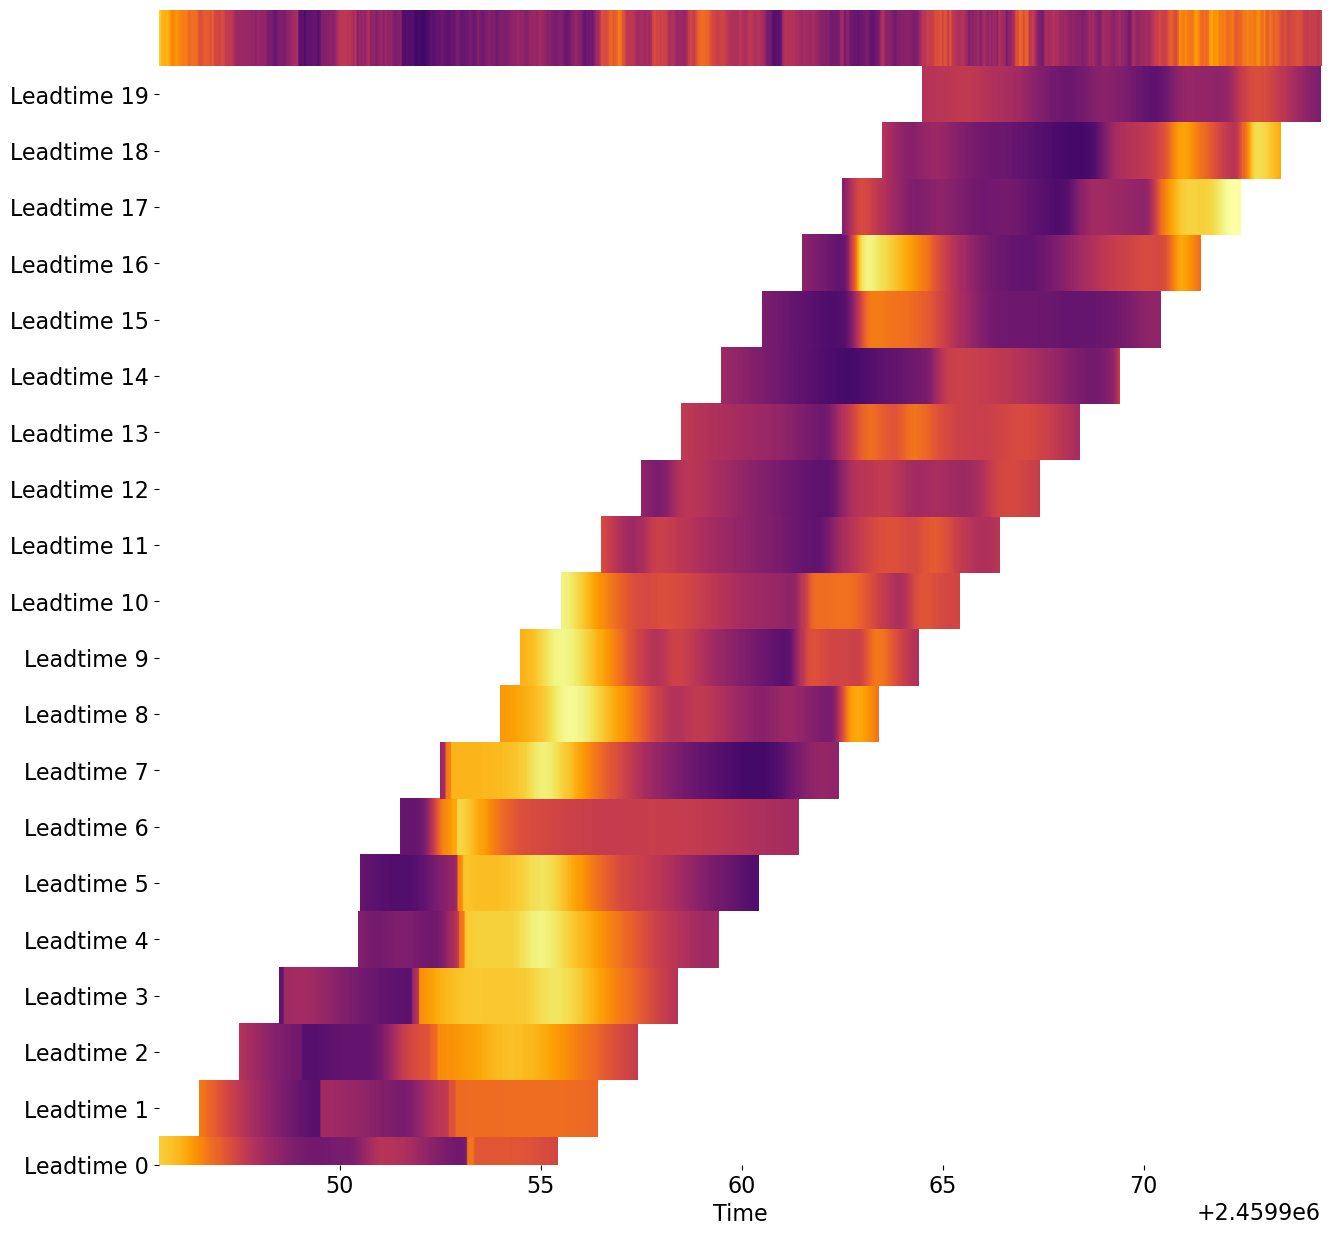

In [335]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 15))

tim_lists = recompiled_time_lists
for_lists = recompiled_forcast_lists
# Create a color map
cmap = plt.get_cmap('inferno')
vmin = 250
vmax= 650

# Plot each time series as a segment in the color bar
for i, (values, times) in enumerate(zip(for_lists, tim_lists)):
    values = np.array(values)
    times = np.array(times)
    norm = plt.Normalize(vmin, vmax)
    colors = cmap(norm(values))
    
    # Create a colored bar for each time series
    ax.imshow([colors], aspect='auto', extent=[times[0], times[-1], i, i + 1])

# Set the x-axis limits to cover all time ranges
all_times = np.concatenate(tim_lists)

#add the observations
mask = (data['mjd'] >= all_times.min() ) & (data['mjd'] <= all_times.max() )
norm = plt.Normalize(vmin, vmax)
colors = cmap(norm(data[mask]['V']))
# Create a colored bar for each time series
ax.imshow([colors], aspect='auto', extent=[all_times.min(), all_times.max(), i+1, i + 2])

# Set the axis labels
ax.set_yticks(np.arange(len(tim_lists)) + 0.5)
ax.set_yticklabels([f'Leadtime {i}' for i in range(len(tim_lists))])
ax.set_xlabel('Time')

ax.set_xlim(all_times.min(), all_times.max())

# Remove axis lines
ax.spines[:].set_visible(False)

plt.show()

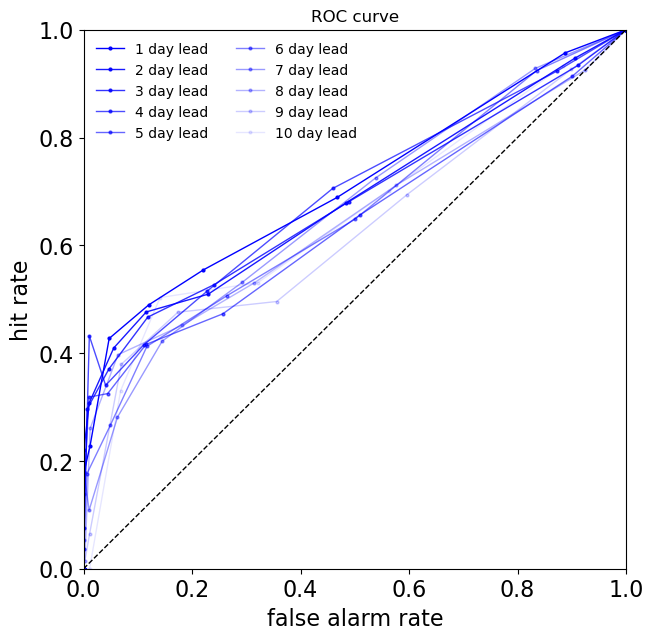

Text(0, 0.5, 'Brier Score')

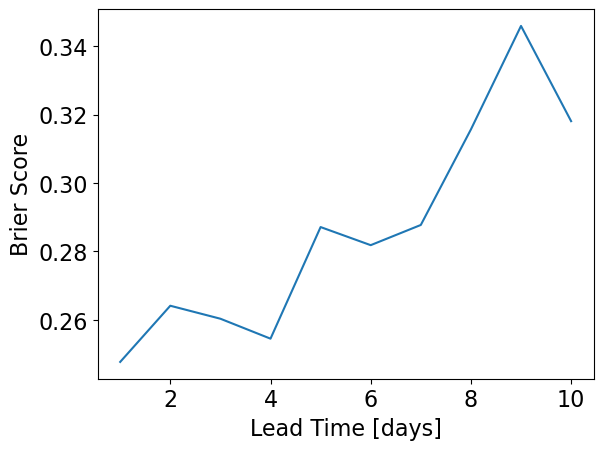

In [135]:
BS_list = []

plt.figure(figsize = (7,7))
max_lead_time = 10
for i in range(max_lead_time):
    df_combined = pd.concat(lead_time_dict[f'{i+1}_day_lead'])
    df_data = pd.concat(lead_time_dict[f'{i+1}_day_data'])

    brier_score = hef.ensemble_brier_score(ensemble_members=df_combined.to_numpy().T, observed_data=df_data.to_numpy(), event_threshold=460, ensemble_size=ensemble_size )
    roc_curve = hef.generate_roc_curve_from_ensemble(ensemble_members=df_combined.to_numpy().T, observed_data=df_data.to_numpy(), threshold_range=(300,800), threshold_num=10, probability_threshold=0.5)

    BS_list.append(brier_score)

    hit_rate, false_alarm_rate = zip(*roc_curve)

    plt.plot(false_alarm_rate, hit_rate, marker = 'o', markersize = 2, linewidth = 1, label = f'{i+1} day lead', color = 'blue', alpha = 1 - i/10)

plt.plot([0,1], [0,1], linestyle = '--', lw = 1, color = 'black')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('ROC curve')
plt.xlabel('false alarm rate')
plt.ylabel('hit rate')
plt.legend(frameon= False, ncols = 2, fontsize = 'medium')
plt.show()

plt.figure()
plt.plot(np.arange(0,max_lead_time)+1, BS_list)
plt.xlabel('Lead Time [days]')
plt.ylabel('Brier Score')

In [7]:
def get_filenames_between_dates(start_date, end_date):

    # get all ensemble netCDF file strings of specified parameters
    ensemble_directory_path = os.path.abspath(os.path.join(os.pardir,'data','ensembles'))
    ensemble_file_words = [f'ens_{int(sigma_latitude)}_{ensemble_size}'] # keywords to filter ensemble set directory
    ensemble_fname = hef.get_files_containing_words(ensemble_directory_path, ensemble_file_words)[0]

    all_files = os.listdir(os.path.abspath(os.path.join(os.pardir,'data','ensembles',ensemble_fname))) # list of all files inside ensemble directory

    dates = []

    # creating list of filenames of ensemble files for reading in ensembles over a specfied date range
    for filename in all_files:

        #unpack ensemble datenum into an indexable datetime obj
        pattern = r'_(\d{4})(\d{2})(\d{2})(\d{2})'
        match = re.search(pattern, filename)
        year, month, day, hour = match.groups()
        date_string = f'{year}-{month}-{day}--{hour}'
        dates.append(datetime.datetime(int(year), int(month), int(day), int(hour)))

    # index ensemble filenames by date
    df_ens_filenames = pd.DataFrame({'file_string' : all_files}, index = dates)
    df_ens_filenames = df_ens_filenames.sort_index()

    date_range = pd.date_range(start_date, end_date, freq='D') # daily frequency

    # Finding closest indices
    indexer = df_ens_filenames.index.get_indexer(date_range, method='nearest')

    # Retrieving the closest rows
    closest_files = df_ens_filenames.iloc[indexer]

    # Dropping duplicates to keep only unique rows -- unlikely for any duplicates but just in case :/ 
    unique_files = closest_files[~closest_files.index.duplicated(keep='first')]

    # list of ensemble netCDF filenames within date_range
    fname_list = unique_files['file_string'].to_list()

    return fname_list


In [57]:
# specify date range of ensemble to load in
start_date = datetime.datetime(2023,1,1)
end_date = datetime.datetime(2023,3,1)

# list of ensemble netCDF filenames within date_range
fname_list = get_filenames_between_dates(start_date, end_date)

# latitude scale parameters to evaluate
latitudes_to_test = np.linspace(0,20,21)

BS_by_lat = []

for sigma_latitude in latitudes_to_test:

    ensemble_size = 100
    sigma_longitude = 5 # degrees
    forecast_window = 10 * u.day
    r_min = 21.5*u.solRad

    max_lead_time = 10 # days
    #fname = fname_list[0]

    # params formatted as a tuple to feed to ensemble gen function
    params = ('dummy_fname', ensemble_size, sigma_latitude, forecast_window, r_min)

    lead_time_dict = split_by_lead_time(params=params, sigma_longitude=sigma_longitude, 
                                        max_lead_time=max_lead_time, observed_data=omni_data, 
                                        filenames=fname_list)
    BS_by_leadtime = []

    for i in range(max_lead_time):

        df_combined = pd.concat(lead_time_dict[f'{i+1}_day_lead'])
        df_data = pd.concat(lead_time_dict[f'{i+1}_day_data'])

        brier_score = hef.ensemble_brier_score(ensemble_members=df_combined.to_numpy().T, observed_data=df_data.to_numpy(), event_threshold=460, ensemble_size=ensemble_size)
        #roc_curve = hef.generate_roc_curve_from_ensemble(ensemble_members=df_combined.to_numpy().T, observed_data=df_data.to_numpy(), threshold_range=(300,800), threshold_num=10, probability_threshold=0.5)
        #print(f'{brier_score:.3f}')
        BS_by_leadtime.append(brier_score)

    BS_by_lat.append(BS_by_leadtime)
        #hit_rate, false_alarm_rate = zip(*roc_curve)

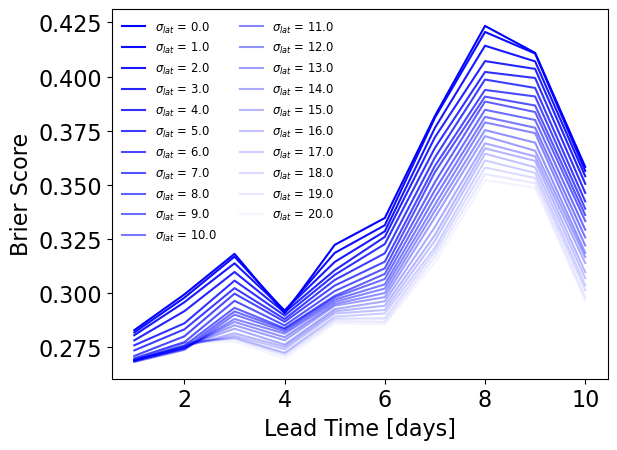

In [68]:
for i, row in enumerate(BS_by_lat):
    plt.plot(np.arange(1,max_lead_time+1), row, color = 'blue', alpha = 1 -i/(len(BS_by_lat)), label = f'$\sigma_{{lat}}$ = {latitudes_to_test[i]}')

plt.legend(frameon = False, ncols = 2, fontsize = 'small')
plt.xlabel('Lead Time [days]')
plt.ylabel('Brier Score')
plt.show()

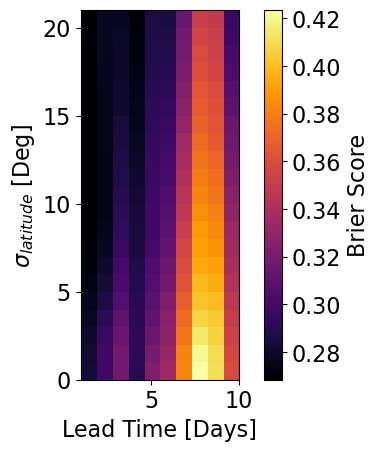

In [74]:
plt.imshow(BS_by_lat, cmap = 'inferno', extent=[1,10,0,21], origin = 'lower')
plt.xlabel('Lead Time [Days]')
plt.ylabel(r'$\sigma_{latitude}$ [Deg]')
#plt.yticks(np.linspace(0,20,6))
plt.colorbar(label = 'Brier Score')
plt.show()

In [8]:
def gen_ranked_ensemble(ensemble_members, observed_data): 

    """
    ranks an ensemble forecast (counts fraction of ensemble members overpredicting observed wind speed)

    Args:
        ensemble_members (list) : list of dataFrames of model runs, timeseries extracted at Earth
        observed_data (dataFrame) : observed near-Earth solar wind speed data
    
    Returns:
        summed_rank (array) : array with counts of ensemble members overprediscting windspeed per timestep
    """
    vsw_list = [] # Initialise list for forecast output

    # Prepare data for rank comparison
    #data_chunk = observed_data.loc[ensemble_members[0].index[0]:ensemble_members[0].index[-1]]
    data_chunk = observed_data#.dropna(subset = ['V']) # Remove rows with NaN values

    # # Interpolate and resample forecast output onto OMNI data time ste[]
    # for vsw in ensemble_members:
    #     vsw_int = hef.interpolate_and_resample(data_chunk, vsw)
    #     vsw_list.append(vsw_int)

    # Compare ensemble member output arrays to omni data 
    vsw_arr = ensemble_members
    ranked_forecast_boolean = np.array([vsw < data_chunk for vsw in vsw_arr])
    summed_ranks = np.sum(ranked_forecast_boolean, axis = 0)

    return summed_ranks

In [9]:
# perturbation scale parameters to evaluate
latitudes_to_test = np.linspace(0,38,39)
#longitudes_to_test = np.linspace(0,33,34)
longitudes_to_test = [0]

# specify date range of ensemble to load in
start_date = datetime.datetime(2023,1,1)
end_date = datetime.datetime(2024,1,1)

# list of ensemble netCDF filenames within date_range
fname_list = get_filenames_between_dates(start_date, end_date)

# Remove rows with NaN values from CME filtered verification dataset
cme_removed_data = df_filtered.dropna(subset = ['V']) 

# ensemble parameters
ensemble_size = 100
forecast_window = 10 * u.day
r_min = 21.5*u.solRad
max_lead_time = 1 # day(s)
lead_time = 1 # day(s)

Chi_by_long = []

for sigma_longitude in longitudes_to_test:
    print(f'now testing sigma_longitude = {sigma_longitude}...')
    chi_across_latitude = []
    t0 = time.time()
    
    for sigma_latitude in latitudes_to_test:
        
        t1 = time.time()
        
        # params formatted as a tuple to feed to ensemble gen function
        params = ('dummy_fname', ensemble_size, sigma_latitude, forecast_window, r_min)

        lead_time_dict = split_by_lead_time(params=params, sigma_longitude=sigma_longitude, 
                                            max_lead_time=max_lead_time, observed_data=cme_removed_data, 
                                            filenames=fname_list)

        df_combined = pd.concat(lead_time_dict[f'{lead_time}_day_lead'])
        df_data = pd.concat(lead_time_dict[f'{lead_time}_day_data'])

        ranked_ensemble = gen_ranked_ensemble(ensemble_members=df_combined.to_numpy().T, observed_data=df_data)
        chi_sq = hef.calculate_rank_chi_square(ensemble_size=ensemble_size, ranked_forecasts=ranked_ensemble)
        
        chi_across_latitude.append(chi_sq)
        t2=time.time()
        print(f'sigma_latitude = {sigma_latitude} evaluated in {t2-t1:.2f} seconds')

    save_chi_arr_by_longitude_to_file(chi_set_list=chi_across_latitude, era_key='2023', sigma_longitude=sigma_longitude, lead_time=lead_time)
    t4 = time.time()
    print(f'sigma_longitude = {sigma_longitude} set evaluated over {t4-t0:.2f} seconds')

    Chi_by_long.append(chi_across_latitude)

#save_chi_arr_to_file(chi_set_list=Chi_by_long, era_key='2023', lead_time=lead_time)


NameError: name 'sigma_latitude' is not defined

In [34]:
longitudes_to_test = [0]
chi_arr = [read_chi_arr_longitude_file('2023', lon, 1) for lon in longitudes_to_test]

In [2]:
def read_chi_arr_by_longitude(era_key, sigma_longitude, lead_time, gen_dist):
    
    fname = f'rank_hist_{era_key}_{int(sigma_longitude)}_{lead_time}_lead{gen_dist}.csv'
    file_path = os.path.abspath(os.path.join(os.pardir,'data','rank_analysis',fname))
    
    return np.genfromtxt(fname = file_path, delimiter=',')

def read_BS_by_longitude(era_key, sigma_longitude, lead_time, threshold, gen_dist):

    fname = f'BS_{era_key}_{int(sigma_longitude)}_{lead_time}_lead_{int(threshold)}{gen_dist}.csv'
    file_path = os.path.abspath(os.path.join(os.pardir,'data','brier_scores',fname))

    return np.genfromtxt(fname = file_path, delimiter=',')

def read_ROC_by_longitude(era_key, sigma_longitude, lead_time, probability_threshold, gen_dist):

    fname = f'ROC_{era_key}_{int(sigma_longitude)}_{lead_time}_lead_{probability_threshold}{gen_dist}.csv'
    file_path = os.path.abspath(os.path.join(os.pardir,'data','roc_scores',fname))
    
    return np.genfromtxt(fname = file_path, delimiter=',')

def read_CAL_by_longitude(era_key, sigma_longitude, lead_time, threshold, gen_dist):

    fname = f'CAL_{era_key}_{int(sigma_longitude)}_{lead_time}_lead_{int(threshold)}{gen_dist}.csv'
    file_path = os.path.abspath(os.path.join(os.pardir,'data','calibration_scores',fname))

    return np.genfromtxt(fname = file_path, delimiter=',')

def read_REF_by_longitude(era_key, sigma_longitude, lead_time, threshold, gen_dist):

    fname = f'REF_{era_key}_{int(sigma_longitude)}_{lead_time}_lead_{int(threshold)}{gen_dist}.csv'
    file_path = os.path.abspath(os.path.join(os.pardir,'data','refinement_scores',fname))

    return np.genfromtxt(fname = file_path, delimiter=',')

def read_REL_by_longitude(era_key, sigma_longitude, lead_time, threshold, gen_dist):

    fname = f'REL_{era_key}_{int(sigma_longitude)}_{lead_time}_lead_{int(threshold)}{gen_dist}.csv'
    file_path = os.path.abspath(os.path.join(os.pardir,'data','reliability_scores',fname))

    return np.genfromtxt(fname = file_path, delimiter=',')

def read_RES_by_longitude(era_key, sigma_longitude, lead_time, threshold, gen_dist):

    fname = f'RES_{era_key}_{int(sigma_longitude)}_{lead_time}_lead_{int(threshold)}{gen_dist}.csv'
    file_path = os.path.abspath(os.path.join(os.pardir,'data','resolution_scores',fname))

    return np.genfromtxt(fname = file_path, delimiter=',')

def read_UNC_by_longitude(era_key, sigma_longitude, lead_time, threshold, gen_dist):

    fname = f'UNC_{era_key}_{int(sigma_longitude)}_{lead_time}_lead_{int(threshold)}{gen_dist}.csv'
    file_path = os.path.abspath(os.path.join(os.pardir,'data','uncertainty_scores',fname))

    return np.genfromtxt(fname = file_path, delimiter=',')

In [51]:
era_key = '2020'
lead_time = 3
longitudes_to_test = np.linspace(0,40,41)
event_threshold = 419
probability_threshold = 0.5
gen_dist = '_uniform'

chi_arr = [read_chi_arr_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, gen_dist=gen_dist) for lon in longitudes_to_test]
brier_arr = [read_BS_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, threshold=event_threshold, gen_dist=gen_dist) for lon in longitudes_to_test]
roc_arr = [read_ROC_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, probability_threshold=probability_threshold, gen_dist=gen_dist) for lon in longitudes_to_test]

RES_arr = [read_RES_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, threshold=event_threshold, gen_dist=gen_dist) for lon in longitudes_to_test]
REL_arr = [read_REL_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, threshold=event_threshold, gen_dist=gen_dist) for lon in longitudes_to_test]
UNC_arr = [read_UNC_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, threshold=event_threshold, gen_dist=gen_dist) for lon in longitudes_to_test]


In [25]:
# Getting minima and 5th percentile contours from rank histogram score grids
grid_range = np.max(np.log10(chi_arr)) - np.min(np.log10(chi_arr))
within_5percent_of_min = np.log10(chi_arr) < np.min(np.log10(chi_arr)) + grid_range*0.1
mindex = np.argwhere(np.log10(chi_arr).T== np.min(np.log10(chi_arr)))[0]

#plt.figure(dpi=300)
im1 = plt.imshow(np.log10(chi_arr).T, cmap = 'inferno', origin = 'lower', vmax = 5.2)
#plt.contour(within_5percent_of_min.T, levels = [0.5], colors='white', corner_mask = True, 
#                                linewidths=1, label = r'$\mathrm{5^th percentile range}$')
#plt.plot(mindex[1], mindex[0], color = 'white', marker = 'o', lw = 0)
plt.xlabel(r'$\sigma_{longitude}$ [Deg]')
plt.ylabel(r'$\sigma_{latitude}$ [Deg]')
#plt.yticks(np.linspace(0,20,6))
plt.colorbar(im1, label = r'$log_{10}\chi^2$')
#plt.contour(np.log10(chi_arr).T, cmap = 'Greys', levels = [np.min(np.log10(chi_arr).T) + grid_range*0.05])
plt.show()

#plt.figure(dpi=300)
mindex = np.argwhere(brier_arr == np.min(brier_arr))[0]
plt.imshow(np.array(brier_arr).T, cmap = 'inferno', origin = 'lower')#, vmax = 0.4, vmin = 0.25)
plt.xlabel(r'$\sigma_{longitude}$ [Deg]')
plt.ylabel(r'$\sigma_{latitude}$ [Deg]')
#plt.yticks(np.linspace(0,20,6))
plt.colorbar(label = 'Brier Score')
plt.plot(mindex[0], mindex[1], color = 'darkred', marker = 'o', lw = 0)
plt.show()
print(mindex)

#plt.figure(dpi=300)
plt.imshow(np.array(roc_arr).T, cmap = 'inferno_r', origin = 'lower')
plt.xlabel(r'$\sigma_{longitude}$ [Deg]')
plt.ylabel(r'$\sigma_{latitude}$ [Deg]')
#plt.yticks(np.linspace(0,20,6))
plt.colorbar(label = 'ROC score')
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (21,) + inhomogeneous part.

[8 0]


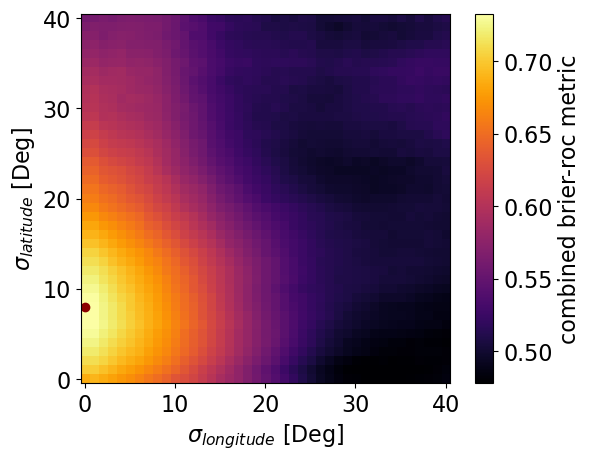

In [9]:
combined_bs_roc = ((1 - np.array(brier_arr) + np.array(roc_arr)))/2
maxdex = np.argwhere(np.log10(combined_bs_roc).T== np.max(np.log10(combined_bs_roc)).T)[0]
print(maxdex)

#plt.figure(dpi=300)
plt.imshow(combined_bs_roc.T, cmap = 'inferno', origin = 'lower')
plt.xlabel(r'$\sigma_{longitude}$ [Deg]')
plt.ylabel(r'$\sigma_{latitude}$ [Deg]')
#plt.yticks(np.linspace(0,20,6))
plt.colorbar(label = 'combined brier-roc metric')

roc_bs_range = np.max(combined_bs_roc) - np.min(combined_bs_roc) 
#plt.contour(np.log10(combined_bs_roc).T, cmap = 'Reds_r', levels = [np.max(np.log10(combined_bs_roc).T) - roc_bs_range*0.05])
plt.plot(maxdex[1], maxdex[0], color = 'darkred', marker = 'o', lw = 0)
plt.show()

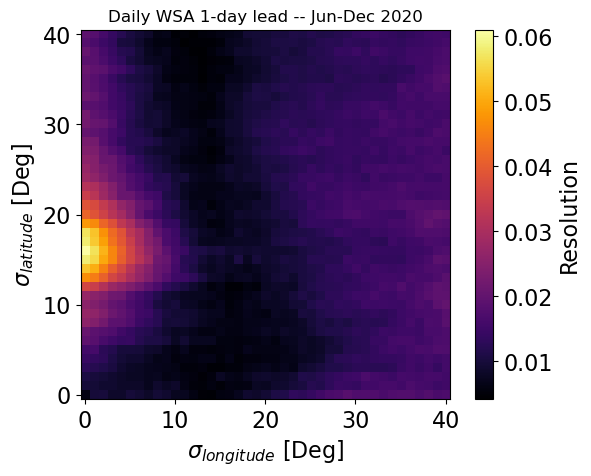

[0 7]


In [10]:
# era_key = '2020'
# lead_time = 1
# longitudes_to_test = np.linspace(0,40,41)
# event_threshold = 507
# probability_threshold = 0.5

# RES_arr = [read_RES_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, threshold=event_threshold) for lon in longitudes_to_test]
# REL_arr = [read_REL_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, threshold=event_threshold) for lon in longitudes_to_test]

plt.imshow(np.array(RES_arr).T, cmap = 'inferno', origin = 'lower')#, vmax = 0.33, vmin = 0.25)
plt.xlabel(r'$\sigma_{longitude}$ [Deg]')
plt.ylabel(r'$\sigma_{latitude}$ [Deg]')
#plt.yticks(np.linspace(0,20,6))
plt.colorbar(label = 'Resolution')
#plt.plot(maxdex[0], maxdex[1], color = 'darkred', marker = 'o', lw = 0)
plt.title('Daily WSA 1-day lead -- Jun-Dec 2020')
plt.show()
print(mindex)


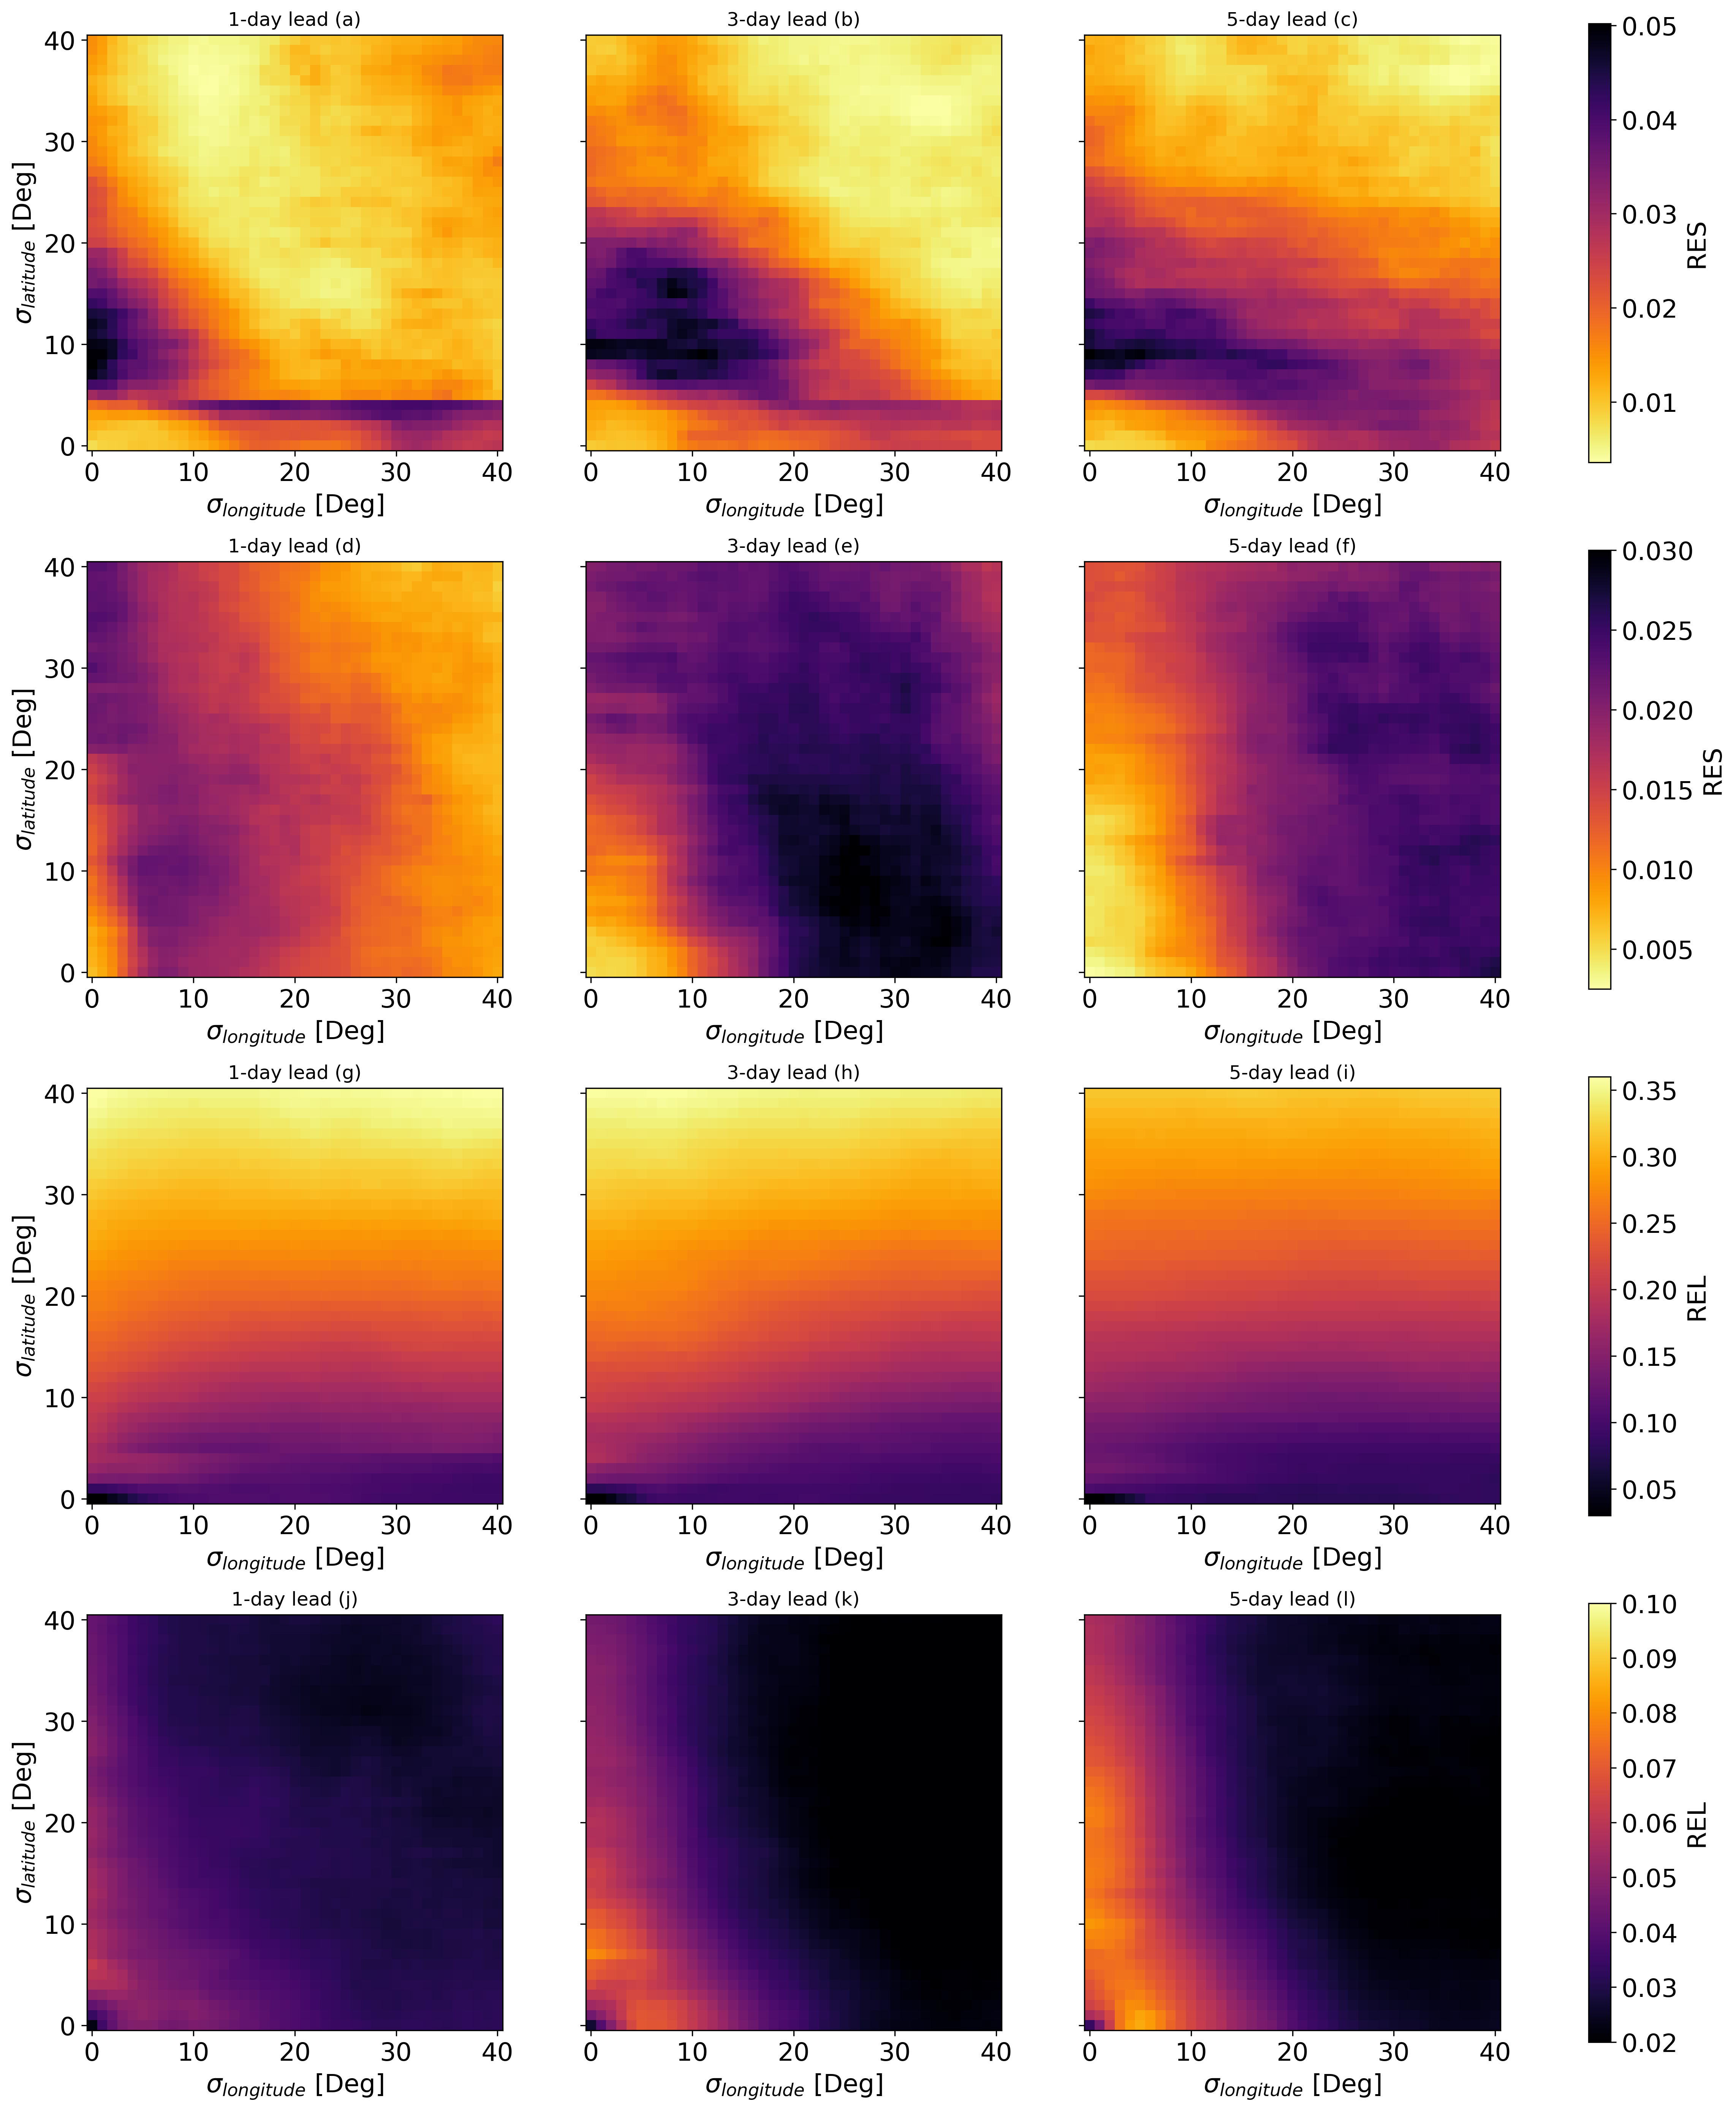

In [55]:
# relevant bits for reading in files
lead_time_list = [1, 3, 5]
longitudes_to_test = np.linspace(0,40,41)
#event_threshold = 460

# Read in RES and REL components
era_key = '2020'
event_threshold = 419
gen_dist = ''

RES_arr_by_lead_2020 = []
for lead_time in lead_time_list:
    RES_arr_temp = [read_RES_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, threshold=event_threshold, gen_dist=gen_dist) for lon in longitudes_to_test]
    RES_arr_by_lead_2020.append(np.array(RES_arr_temp).T)

REL_arr_by_lead_2020 = []
for lead_time in lead_time_list:
    REL_arr_temp = [read_REL_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, threshold=event_threshold, gen_dist=gen_dist) for lon in longitudes_to_test]
    REL_arr_by_lead_2020.append(np.array(REL_arr_temp).T)

era_key = '2023'
event_threshold = 460
gen_dist = ''
RES_arr_by_lead_2023 = []
for lead_time in lead_time_list:
    RES_arr_temp = [read_RES_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, threshold=event_threshold, gen_dist=gen_dist) for lon in longitudes_to_test]
    RES_arr_by_lead_2023.append(np.array(RES_arr_temp).T)


REL_arr_by_lead_2023 = []
for lead_time in lead_time_list:
    REL_arr_temp = [read_REL_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, threshold=event_threshold, gen_dist=gen_dist) for lon in longitudes_to_test]
    REL_arr_by_lead_2023.append(np.array(REL_arr_temp).T)


# Plotting colourmaps
fig, axes = plt.subplots(nrows=4, ncols=3,dpi=300,figsize=(20,23), sharey=True)

panel_letter = ['(a)','(b)','(c)']
for i, RES_arr in enumerate(RES_arr_by_lead_2020):
    im = axes[0,i].imshow(RES_arr, cmap = 'inferno_r', origin = 'lower')#, vmin = 0.0025, vmax = 0.05)
    axes[0,i].set_xlabel(r'$\sigma_{longitude}$ [Deg]')
    axes[0,i].set_title(f'{lead_time_list[i]}-day lead {panel_letter[i]}')

panel_letter = ['(d)','(e)','(f)']
for i, RES_arr in enumerate(RES_arr_by_lead_2023):
    im1 = axes[1,i].imshow(RES_arr, cmap = 'inferno_r', origin = 'lower', vmin = 0.0025, vmax = 0.03)
    axes[1,i].set_xlabel(r'$\sigma_{longitude}$ [Deg]')
    axes[1,i].set_title(f'{lead_time_list[i]}-day lead {panel_letter[i]}')

panel_letter = ['(g)','(h)','(i)']
for i, REL_arr in enumerate(REL_arr_by_lead_2020):
    im2 = axes[2,i].imshow(REL_arr, cmap = 'inferno', origin = 'lower', vmin = 0.03, vmax = 0.36)
    axes[2,i].set_xlabel(r'$\sigma_{longitude}$ [Deg]')
    axes[2,i].set_title(f'{lead_time_list[i]}-day lead {panel_letter[i]}')

panel_letter = ['(j)','(k)','(l)']
for i, REL_arr in enumerate(REL_arr_by_lead_2023):
    im3 = axes[3,i].imshow(REL_arr, cmap = 'inferno', origin = 'lower', vmin = 0.02, vmax = 0.1)
    axes[3,i].set_xlabel(r'$\sigma_{longitude}$ [Deg]')
    axes[3,i].set_title(f'{lead_time_list[i]}-day lead {panel_letter[i]}')

axes[0,0].set_ylabel(r'$\sigma_{latitude}$ [Deg]')
axes[1,0].set_ylabel(r'$\sigma_{latitude}$ [Deg]')
axes[2,0].set_ylabel(r'$\sigma_{latitude}$ [Deg]')
axes[3,0].set_ylabel(r'$\sigma_{latitude}$ [Deg]')

fig.colorbar(im, ax = axes[0,:], label = r'RES', orientation = 'vertical', aspect = 20, pad = 0.05)
fig.colorbar(im1, ax = axes[1,:], label = r'RES', orientation = 'vertical', aspect = 20, pad = 0.05)
fig.colorbar(im2, ax = axes[2,:], label = r'REL', orientation = 'vertical', aspect = 20, pad = 0.05)
fig.colorbar(im3, ax = axes[3,:], label = r'REL', orientation = 'vertical', aspect = 20, pad = 0.05)

filename = "wsa_RES_REL_across_lead_time.pdf"
fpath = f"C:\\Users\\ct832900\\OneDrive - University of Reading\\WSA calibration paper\\figures_01\\{filename}"
#plt.savefig(fpath, format = 'pdf', dpi = 300, bbox_inches='tight')

plt.show()

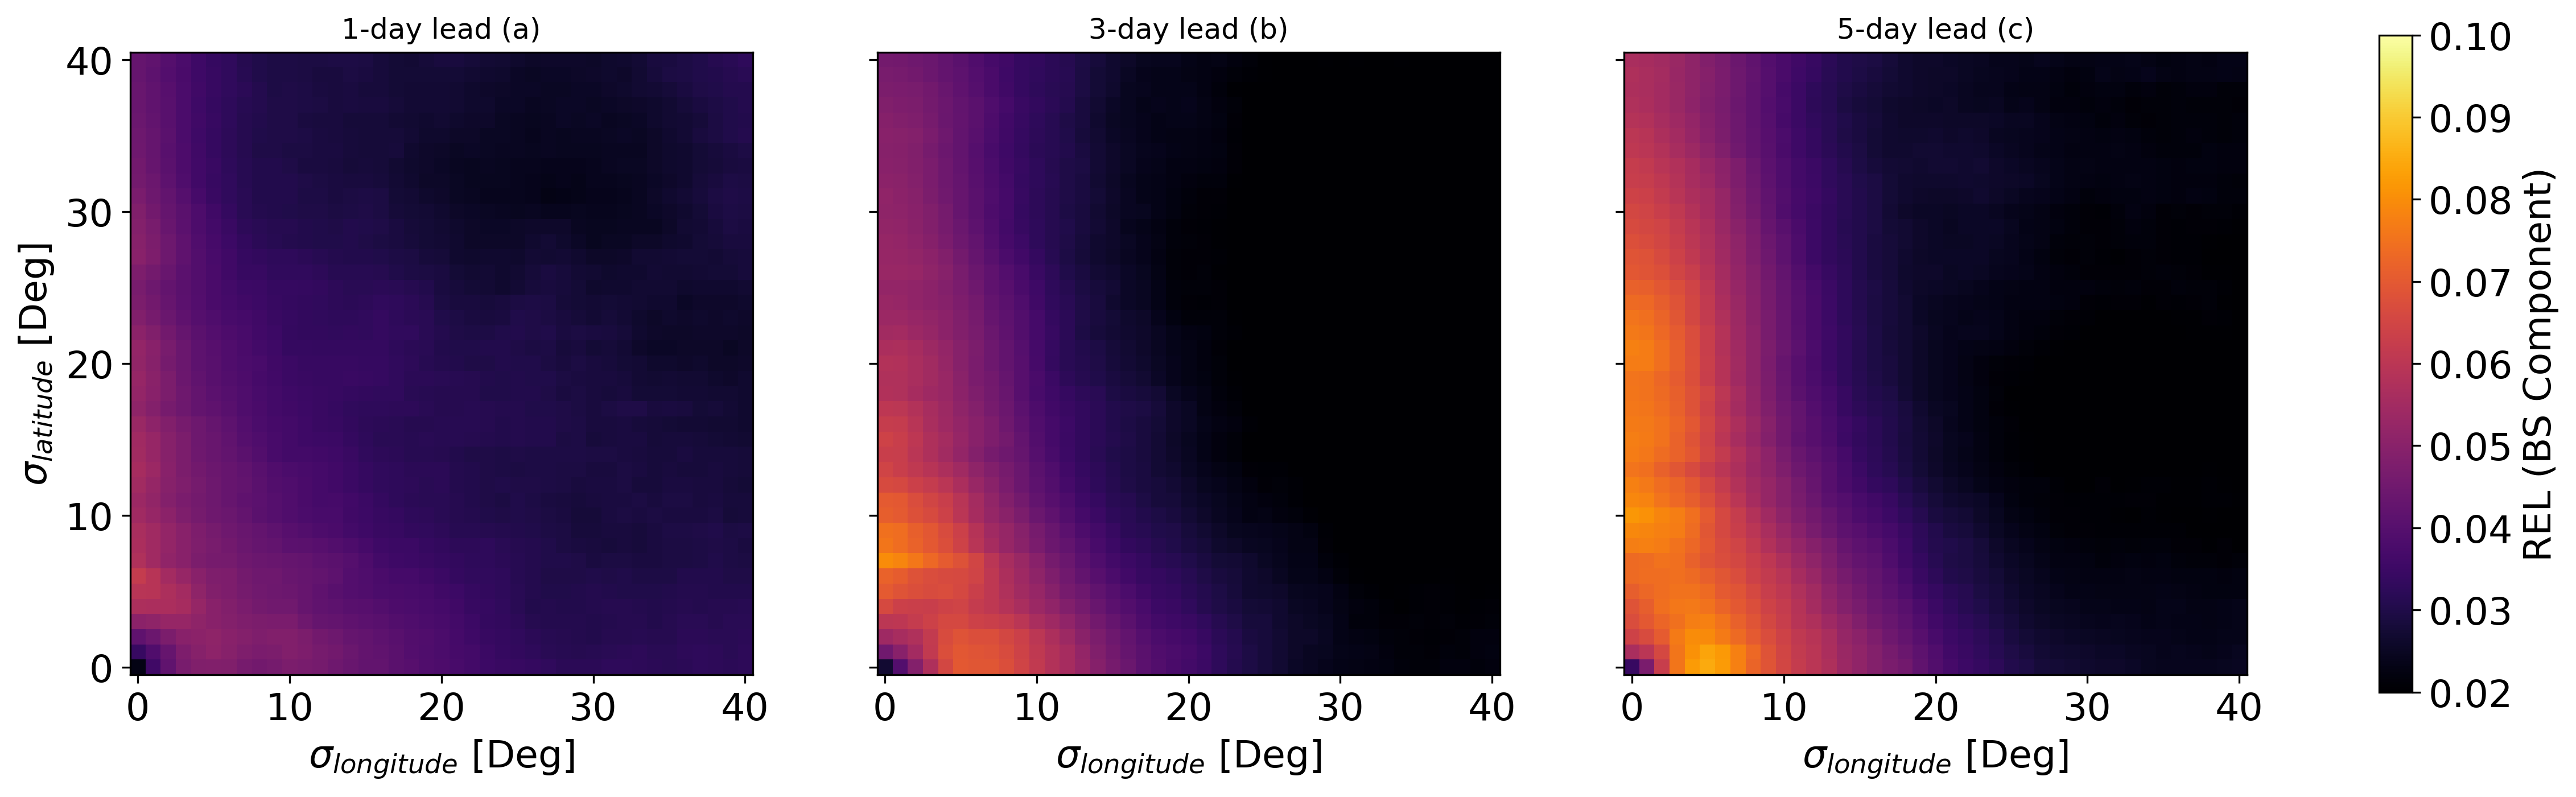

In [10]:

era_key = '2023'
lead_time_list = [1,3,5]
longitudes_to_test = np.linspace(0,40,41)
panel_letter = ['(a)', '(b)','(c)']
event_threshold = 460

REL_arr_by_lead = []

for lead_time in lead_time_list:
    REL_arr_temp = [read_REL_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, threshold=event_threshold) for lon in longitudes_to_test]
    REL_arr_by_lead.append(np.array(REL_arr_temp).T)

fig, axes = plt.subplots(nrows=1, ncols=3,dpi=300,figsize=(20,5), sharey=True)

for i, REL_arr in enumerate(REL_arr_by_lead):
    im = axes[i].imshow(REL_arr, cmap = 'inferno', origin = 'lower', vmin = 0.02, vmax = 0.1)
    axes[i].set_xlabel(r'$\sigma_{longitude}$ [Deg]')
    axes[i].set_title(f'{lead_time_list[i]}-day lead {panel_letter[i]}')

axes[0].set_ylabel(r'$\sigma_{latitude}$ [Deg]')

fig.colorbar(im, ax = axes, label = r'REL (BS Component)', orientation = 'vertical', aspect = 20, pad = 0.05)

filename = "wsa_REL_across_lead_time_2023.svg"
fpath = f"C:\\Users\\ct832900\\OneDrive - University of Reading\\WSA calibration paper\\figures_01\\{filename}"
#plt.savefig(fpath, format = 'svg', dpi = 300, bbox_inches='tight')

plt.show()

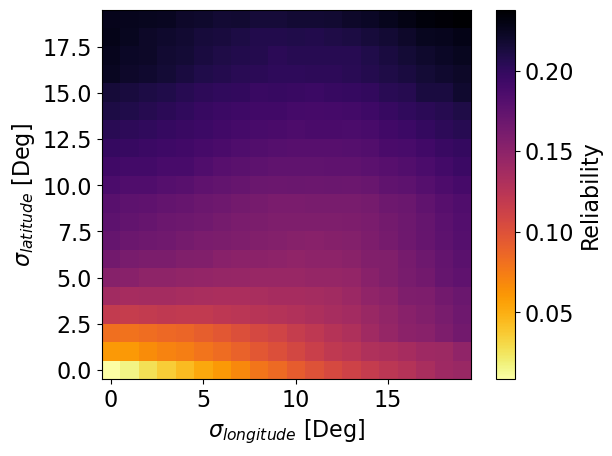

NameError: name 'mindex' is not defined

In [11]:
plt.imshow(np.array(REL_arr).T, cmap = 'inferno_r', origin = 'lower')#, vmax = 0.33, vmin = 0.25)
plt.xlabel(r'$\sigma_{longitude}$ [Deg]')
plt.ylabel(r'$\sigma_{latitude}$ [Deg]')
#plt.yticks(np.linspace(0,20,6))
plt.colorbar(label = 'Reliability')
#plt.plot(mindex[1], mindex[0], color = 'darkred', marker = 'o', lw = 0)
plt.show()
print(mindex)


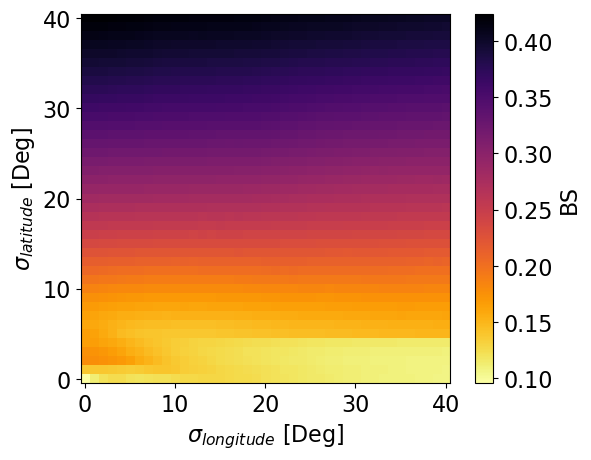

[40  1]


In [30]:
BS_reconstructed = np.array(REL_arr) - np.array(RES_arr) + np.array(UNC_arr)

plt.imshow(BS_reconstructed.T, cmap = 'inferno_r', origin = 'lower')#, vmax = 0.4, vmin = 0.25)
plt.xlabel(r'$\sigma_{longitude}$ [Deg]')
plt.ylabel(r'$\sigma_{latitude}$ [Deg]')
#plt.yticks(np.linspace(0,20,6))
plt.colorbar(label = 'BS')
#plt.plot(mindex[0], mindex[1], color = 'darkred', marker = 'o', lw = 0)
plt.show()
print(mindex)


In [32]:
def compute_brier_score(forecast, data):
    return np.mean((forecast - data)**2)

In [31]:
def compute_brier_score_components(forecasts, observations, n_bins):
    """
    Computes the Brier score and components (reliability, resolution, and uncertainty).

    Parameters:
    - forecasts: Array of predicted probabilities for the event.
    - observations: Array of binary observations
    - n_bins: Number of bins to group forecasts

    Returns:
    - brier_score
    - reliability
    - resolution
    - uncertainty
    """
    
    # Convert inputs to numpy arrays
    forecasts = np.array(forecasts)
    observations = np.array(observations)

    # compute the single metric brier score
    brier_score = np.mean((forecasts - observations) ** 2)

    # define bins based on forecast probabilities
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(forecasts, bins) - 1
    
    # initialise components
    reliability = 0.0
    resolution = 0.0
    uncertainty = 0.0
    
    # mean event frequency
    event_frequency = np.mean(observations)
    uncertainty = event_frequency * (1 - event_frequency)
    
    # Loop through each bin to calculate reliability and resolution components
    for i in range(n_bins):
        bin_mask = bin_indices == i
        bin_forecasts = forecasts[bin_mask]
        bin_observations = observations[bin_mask]
        
        if len(bin_observations) > 0:
            # Calculate the mean forecast and observation frequency in the bin
            bin_forecast_prob = np.mean(bin_forecasts)
            bin_observed_freq = np.mean(bin_observations)
            
            # Reliability: difference between forecasted and observed probability in each bin
            reliability += len(bin_observations) * ((bin_forecast_prob - bin_observed_freq) ** 2) / len(forecasts)
            
            # Resolution: difference between bin observation frequency and overall event frequency
            resolution += len(bin_observations) * ((bin_observed_freq - event_frequency) ** 2) / len(forecasts)
    
    return {"brier_score": brier_score, "reliability": reliability, "resolution": resolution, "uncertainty": uncertainty}


In [40]:
random_seed = 10
rng = np.random.default_rng(random_seed)
N = 100
probabilistic_forecast = rng.uniform(0,1,size=N)
#print(probabilistic_forecast)
verification_data = np.round(rng.uniform(0,1,size=N))
#print(verification_data)

BS = compute_brier_score(forecast=probabilistic_forecast, data = verification_data)
BS_new = compute_brier_score_components(forecasts=probabilistic_forecast, observations=verification_data, n_bins=100)
print(BS)
print(BS_new)
print(BS_new['reliability'] - BS_new['resolution'] + BS_new['uncertainty'])

0.3813046223694672
{'brier_score': 0.3813046223694672, 'reliability': 0.2938035634825293, 'resolution': 0.1525, 'uncertainty': 0.24}
0.38130356348252925


In [84]:
prob_chunk = []
time_axis_chunk = []

event_threshold = 460
for set in lead_time_dict['1_day_lead']:
    prob_chunk.append(np.mean(set > event_threshold, axis = 1))
    time_axis_chunk.append(set.index)
    
data_chunk = []
for data in lead_time_dict['1_day_data']:
    data_chunk.append(data > event_threshold)

verification_data = np.concatenate(data_chunk)
probabilistic_forecast = np.concatenate(prob_chunk)   
time_axis = np.concatenate(time_axis_chunk)

#plt.plot(time_axis, probabilistic_forecast)
#plt.plot(time_axis, verification_data)
BS_comp = compute_brier_score_components(forecasts=probabilistic_forecast, observations=verification_data, n_bins=10)
print(compute_brier_score(forecast=probabilistic_forecast, data=verification_data))
print(BS_comp)
print(BS_comp['reliability'] - BS_comp['resolution'] + BS_comp['uncertainty'])

0.25024740319962907
{'brier_score': 0.25024740319962907, 'reliability': 0.05439191948921838, 'resolution': 0.012008754442115775, 'uncertainty': 0.204598300857291}
0.2469814659043936


In [14]:
def read_rank_hist_file(era_key):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\rank_analysis\\rank_hist_{era_key}.csv'
    return np.genfromtxt(fname = fname, delimiter=',')

CR_chunk_key = ['min', 'other', 'max']
MAS_rank_histogram_grids = [read_rank_hist_file(key) for key in CR_chunk_key]

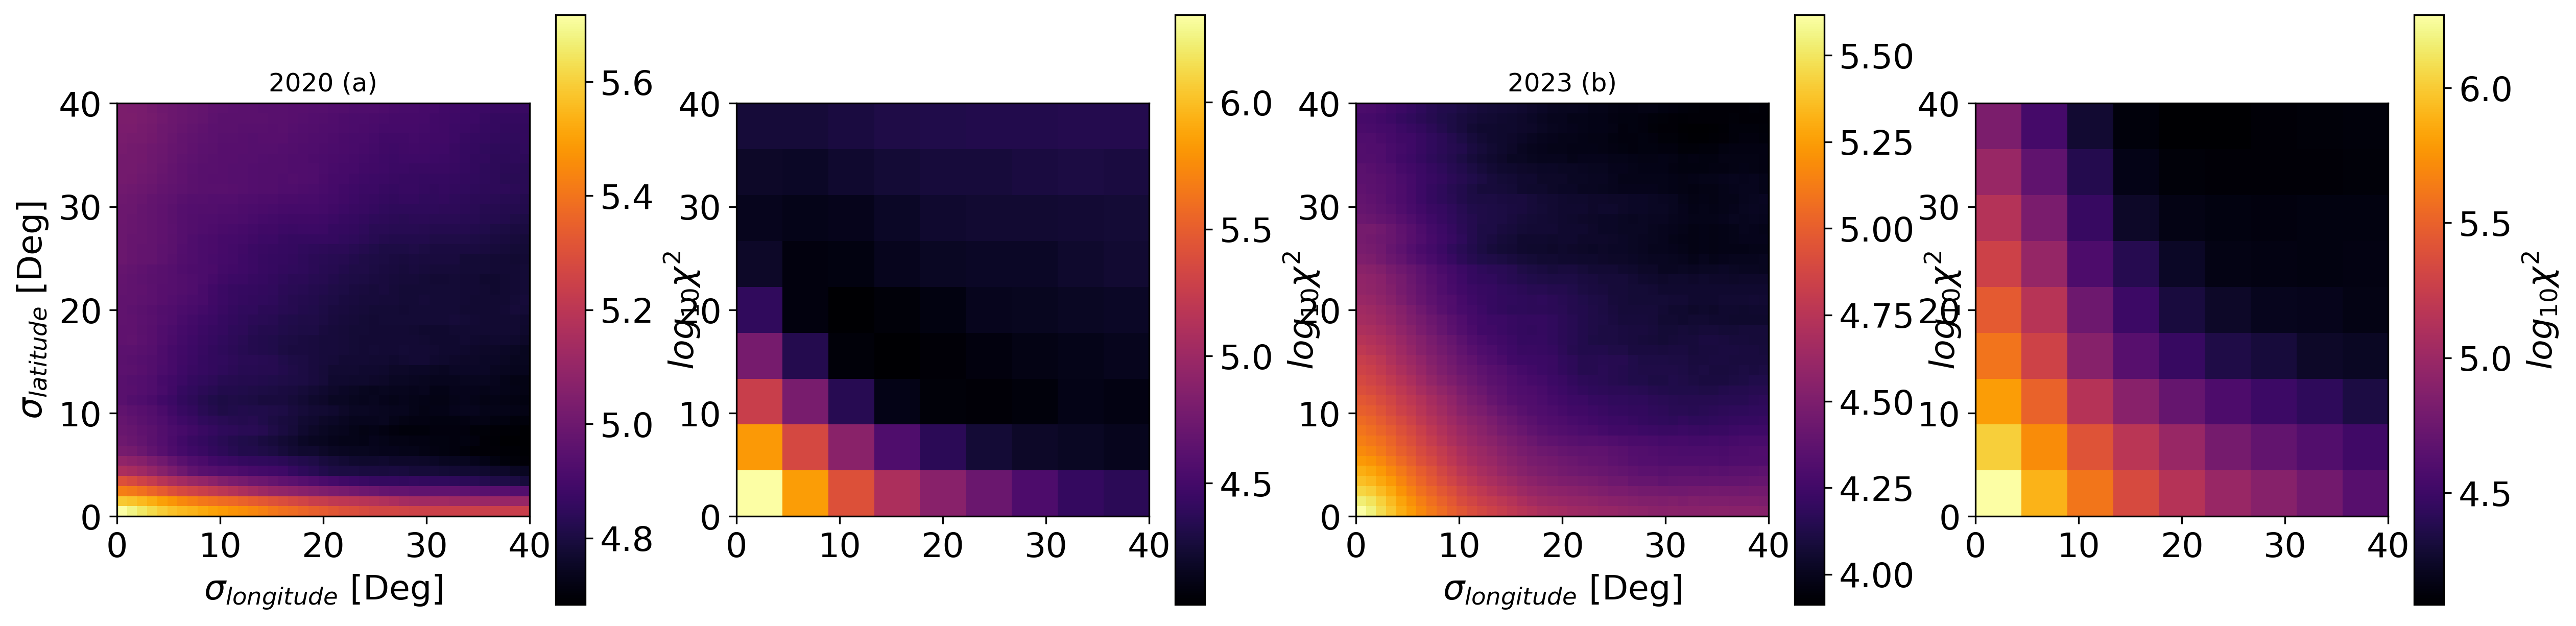

In [15]:
longitudes_to_test = np.linspace(0,40,41)
event_threshold = 460
probability_threshold = 0.5

chi_arr_2023 = [read_chi_arr_by_longitude(era_key='2023', sigma_longitude=lon, lead_time=lead_time) for lon in longitudes_to_test]
chi_arr_2020 = [read_chi_arr_by_longitude(era_key='2020', sigma_longitude=lon, lead_time=lead_time) for lon in longitudes_to_test]


fig, axes = plt.subplots(nrows=1, ncols=4,dpi=300,figsize=(20,5))


im = axes[0].imshow(np.log10(chi_arr_2020).T, cmap = 'inferno', origin = 'lower', extent=[0,40,0,40])
axes[0].set_xlabel(r'$\sigma_{longitude}$ [Deg]')
axes[0].set_title('2020 (a)')

im1 = axes[1].imshow(np.log10(MAS_rank_histogram_grids[0]), extent=[0,40,0,40], cmap = 'inferno', origin = 'lower')


im2 = axes[2].imshow(np.log10(chi_arr_2023).T, cmap = 'inferno', origin = 'lower', extent=[0,40,0,40])
axes[2].set_xlabel(r'$\sigma_{longitude}$ [Deg]')
axes[2].set_title('2023 (b)')


im3 = axes[3].imshow(np.log10(MAS_rank_histogram_grids[2]), extent=[0,40,0,40], cmap = 'inferno', origin = 'lower')


axes[0].set_ylabel(r'$\sigma_{latitude}$ [Deg]')

fig.colorbar(im, ax = axes[0], label = r'$log_{10}\chi^2$', orientation = 'vertical', aspect = 20, pad = 0.05)
fig.colorbar(im2, ax = axes[2], label = r'$log_{10}\chi^2$', orientation = 'vertical', aspect = 20, pad = 0.05)
fig.colorbar(im1, ax = axes[1], label = r'$log_{10}\chi^2$', orientation = 'vertical', aspect = 20, pad = 0.05)
fig.colorbar(im3, ax = axes[3], label = r'$log_{10}\chi^2$', orientation = 'vertical', aspect = 20, pad = 0.05)
filename = "rank_histogram_arrays.pdf"
fpath = f"C:\\Users\\ct832900\\OneDrive - University of Reading\\WSA calibration paper\\figures_01\\{filename}"
#plt.savefig(fpath, format = 'svg', dpi = 300, bbox_inches='tight')

plt.show()


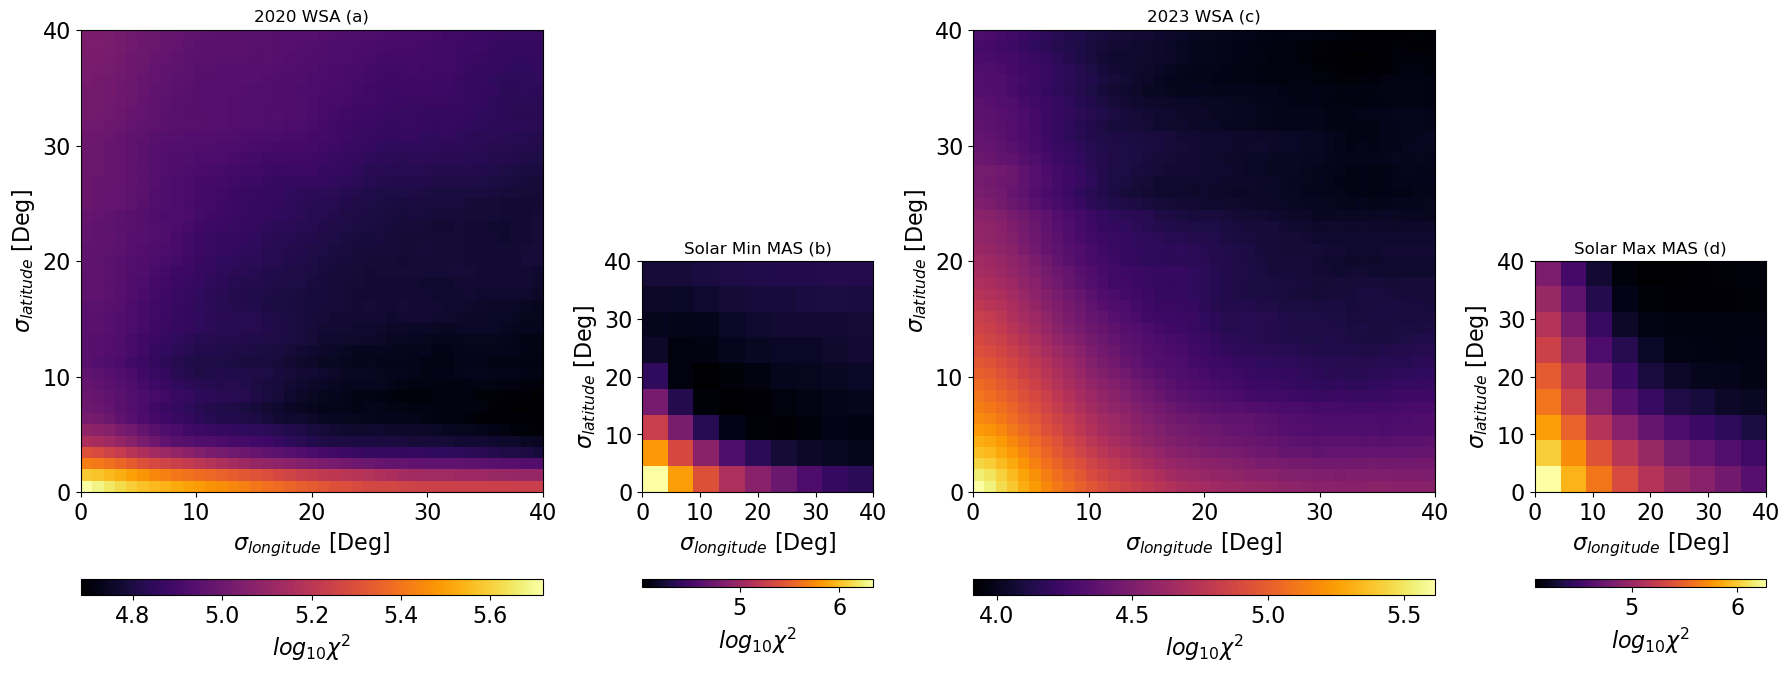

In [16]:

fig = plt.figure(figsize=(18, 9))  
gs = plt.GridSpec(1, 4, width_ratios=[1.0, 0.5, 1, 0.5])  


ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

# List of images and axes
images = [np.log10(chi_arr_2020).T, np.log10(MAS_rank_histogram_grids[0]), np.log10(chi_arr_2023).T, np.log10(MAS_rank_histogram_grids[2])]
axes = [ax1, ax2, ax3, ax4]
titles = ['2020 WSA (a)', 'Solar Min MAS (b)', '2023 WSA (c)', 'Solar Max MAS (d)']

# Plot images
i=0
for ax, img in zip(axes, images):
    im_ax = ax.imshow(img, origin='lower', cmap='inferno', extent=[0,40,0,40])
    #ax.axis('off')  
    ax.set_aspect('equal')
    ax.set_xlabel(r'$\sigma_{longitude}$ [Deg]')
    ax.set_ylabel(r'$\sigma_{latitude}$ [Deg]')
    ax.set_xticks(np.linspace(0,40,5))
    ax.set_yticks(np.linspace(0,40,5))
    ax.set_title(titles[i])
    fig.colorbar(im_ax, ax = ax, label = r'$log_{10}\chi^2$', orientation = 'horizontal', aspect = 30, pad = 0.1)
    i+=1


plt.tight_layout()

filename = "rank_histogram_arrays.pdf"
fpath = f"C:\\Users\\ct832900\\OneDrive - University of Reading\\WSA calibration paper\\figures_01\\{filename}"
#plt.savefig(fpath, format = 'pdf', dpi = 300, bbox_inches='tight')
  # Adjust layout
plt.show()